In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pandas as pd

In [2]:
df = pd.read_csv("../../data/clean/bitcoin_prices.csv")

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)

start_date = datetime.datetime(2017,12,22)
df = df[df["Time"] > start_date]
df.describe()

,Unnamed: 0,Low,High,Open,Close,Volume
count,26454.000000,26454.000000,26454.000000,26454.000000,26454.000000,26454.000000
mean,34470.500000,8592.849512,8683.142329,8640.119377,8640.564778,589.522846
std,7636.756347,3470.928023,3521.830768,3497.624038,3499.219337,798.610912
min,21244.000000,3128.890000,3153.590000,3139.830000,3139.830000,0.286254
25%,27857.250000,6462.625000,6510.029844,6489.169219,6487.257500,203.032383
50%,34470.500000,8281.680000,8354.500000,8318.165000,8318.160000,357.922407
75%,41083.750000,10111.865000,10209.442500,10164.997500,10165.360000,665.378504
max,47697.000000,27666.960000,28387.000000,27803.510000,27803.470000,19591.576090


In [3]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [4]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    data = bt.feeds.PandasData(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


In [5]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.PandasData(dataname=df)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=0.01)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)
    
    cerebro.broker.addcommissioninfo(CommInfoFractional())

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00
2017-12-22, Close, 13299.99
2017-12-22, Close, 12998.19
2017-12-22, Close, 13130.13
2017-12-22, Close, 13489.00
2017-12-22, Close, 13410.00
2017-12-22, Close, 14765.88
2017-12-22, BUY CREATE, 14765.88
2017-12-22, BUY EXECUTED, Price: 14763.38, Cost: 147.63, Comm 0.00
2017-12-22, Close, 14475.04
2017-12-22, Close, 15452.97
2017-12-22, Close, 14210.57
2017-12-23, Close, 14470.89
2017-12-23, Close, 14357.44
2017-12-23, Close, 14550.00
2017-12-23, Close, 14976.01
2017-12-23, Close, 14799.99
2017-12-23, Close, 14318.74
2017-12-23, Close, 14279.00
2017-12-23, Close, 14503.02
2017-12-23, Close, 14625.83
2017-12-23, Close, 14863.52
2017-12-23, Close, 15080.98
2017-12-23, Close, 15459.00
2017-12-23, Close, 15325.00
2017-12-23, Close, 15399.99
2017-12-23, Close, 15997.79
2017-12-23, Close, 15505.70
2017-12-23, Close, 15771.86
2017-12-23, Close, 15590.44
2017-12-23, Close, 15574.48
2017-12-23, Close, 15611.15
2017-12-23, Close, 15765.51
2017-12-23, Close, 15830.7

2018-01-08, Close, 14870.00
2018-01-08, Close, 14465.84
2018-01-08, Close, 14621.56
2018-01-08, Close, 14901.99
2018-01-08, Close, 14870.02
2018-01-08, Close, 15025.01
2018-01-08, Close, 15120.00
2018-01-08, Close, 14990.00
2018-01-08, Close, 14948.26
2018-01-08, Close, 14735.01
2018-01-08, Close, 14993.74
2018-01-09, Close, 15259.99
2018-01-09, BUY CREATE, 15259.99
2018-01-09, BUY EXECUTED, Price: 15259.99, Cost: 152.60, Comm 0.00
2018-01-09, Close, 15268.99
2018-01-09, Close, 15239.91
2018-01-09, Close, 15263.60
2018-01-09, Close, 15328.99
2018-01-09, Close, 15085.49
2018-01-09, Close, 14998.00
2018-01-09, SELL CREATE, 14998.00
2018-01-09, SELL EXECUTED, Price: 14998.00, Cost: 152.60, Comm 0.00
2018-01-09, OPERATION PROFIT, GROSS -2.62, NET -2.62
2018-01-09, Close, 15147.35
2018-01-09, BUY CREATE, 15147.35
2018-01-09, BUY EXECUTED, Price: 15147.35, Cost: 151.47, Comm 0.00
2018-01-09, Close, 15171.77
2018-01-09, Close, 14910.01
2018-01-09, SELL CREATE, 14910.01
2018-01-09, SELL EXECUT

2018-01-22, OPERATION PROFIT, GROSS -0.51, NET -0.51
2018-01-22, Close, 11583.50
2018-01-22, BUY CREATE, 11583.50
2018-01-22, BUY EXECUTED, Price: 11583.50, Cost: 115.84, Comm 0.00
2018-01-22, Close, 11455.00
2018-01-22, Close, 11615.74
2018-01-22, Close, 11720.00
2018-01-22, Close, 11712.39
2018-01-22, Close, 11710.01
2018-01-22, Close, 11684.77
2018-01-22, Close, 11306.01
2018-01-22, SELL CREATE, 11306.01
2018-01-22, SELL EXECUTED, Price: 11306.01, Cost: 115.84, Comm 0.00
2018-01-22, OPERATION PROFIT, GROSS -2.77, NET -2.77
2018-01-22, Close, 11308.23
2018-01-22, Close, 10596.51
2018-01-22, Close, 10635.00
2018-01-22, Close, 10408.92
2018-01-22, Close, 10499.58
2018-01-22, Close, 10581.62
2018-01-22, Close, 10453.00
2018-01-22, Close, 10590.00
2018-01-22, Close, 10395.23
2018-01-22, Close, 10381.19
2018-01-22, Close, 10654.30
2018-01-22, Close, 10766.70
2018-01-23, Close, 10790.00
2018-01-23, BUY CREATE, 10790.00
2018-01-23, BUY EXECUTED, Price: 10789.99, Cost: 107.90, Comm 0.00
2018

2018-02-04, Close, 8414.18
2018-02-04, Close, 8167.91
2018-02-05, Close, 8210.74
2018-02-05, Close, 8085.00
2018-02-05, Close, 8031.79
2018-02-05, Close, 8133.00
2018-02-05, Close, 8273.00
2018-02-05, BUY CREATE, 8273.00
2018-02-05, BUY EXECUTED, Price: 8272.99, Cost: 82.73, Comm 0.00
2018-02-05, Close, 8197.45
2018-02-05, SELL CREATE, 8197.45
2018-02-05, SELL EXECUTED, Price: 8197.45, Cost: 82.73, Comm 0.00
2018-02-05, OPERATION PROFIT, GROSS -0.76, NET -0.76
2018-02-05, Close, 8061.14
2018-02-05, Close, 7986.78
2018-02-05, Close, 7800.01
2018-02-05, Close, 7884.01
2018-02-05, Close, 7681.95
2018-02-05, Close, 7560.00
2018-02-05, Close, 7700.00
2018-02-05, Close, 7655.03
2018-02-05, Close, 7325.09
2018-02-05, Close, 7335.00
2018-02-05, Close, 7265.42
2018-02-05, Close, 7000.99
2018-02-05, Close, 6858.11
2018-02-05, Close, 6530.75
2018-02-05, Close, 7137.55
2018-02-05, Close, 7078.34
2018-02-05, Close, 6801.01
2018-02-05, Close, 6905.19
2018-02-06, Close, 6975.00
2018-02-06, Close, 648

2018-02-20, Close, 11770.00
2018-02-20, Close, 11711.77
2018-02-20, Close, 11376.07
2018-02-20, SELL CREATE, 11376.07
2018-02-20, SELL EXECUTED, Price: 11376.06, Cost: 108.16, Comm 0.00
2018-02-20, OPERATION PROFIT, GROSS 5.60, NET 5.60
2018-02-20, Close, 11235.57
2018-02-21, Close, 11085.00
2018-02-21, Close, 11115.00
2018-02-21, Close, 11056.95
2018-02-21, Close, 10922.99
2018-02-21, Close, 10749.15
2018-02-21, Close, 10824.54
2018-02-21, Close, 11075.20
2018-02-21, Close, 11126.97
2018-02-21, Close, 11039.07
2018-02-21, Close, 11176.13
2018-02-21, Close, 10969.99
2018-02-21, Close, 10958.01
2018-02-21, Close, 11049.00
2018-02-21, Close, 10735.01
2018-02-21, Close, 10650.00
2018-02-21, Close, 10588.00
2018-02-21, Close, 10469.00
2018-02-21, Close, 10548.69
2018-02-21, Close, 10537.01
2018-02-21, Close, 10419.97
2018-02-21, Close, 10395.00
2018-02-21, Close, 10282.60
2018-02-21, Close, 10455.00
2018-02-21, Close, 10454.27
2018-02-22, Close, 10488.99
2018-02-22, Close, 10637.32
2018-02

2018-03-07, Close, 10664.99
2018-03-07, Close, 10505.01
2018-03-07, Close, 10524.08
2018-03-07, Close, 10552.99
2018-03-07, Close, 10476.99
2018-03-07, Close, 10490.00
2018-03-07, Close, 10641.72
2018-03-07, Close, 10604.64
2018-03-07, Close, 10545.00
2018-03-07, Close, 10650.00
2018-03-07, BUY CREATE, 10650.00
2018-03-07, BUY EXECUTED, Price: 10650.00, Cost: 106.50, Comm 0.00
2018-03-07, Close, 10655.01
2018-03-07, Close, 9947.12
2018-03-07, SELL CREATE, 9947.12
2018-03-07, SELL EXECUTED, Price: 9947.12, Cost: 106.50, Comm 0.00
2018-03-07, OPERATION PROFIT, GROSS -7.03, NET -7.03
2018-03-07, Close, 9735.81
2018-03-07, Close, 9678.36
2018-03-07, Close, 9855.99
2018-03-07, Close, 9777.75
2018-03-07, Close, 9960.02
2018-03-07, Close, 9935.00
2018-03-07, Close, 9925.00
2018-03-08, Close, 9952.00
2018-03-08, Close, 9872.00
2018-03-08, Close, 9648.15
2018-03-08, Close, 9560.19
2018-03-08, Close, 9790.17
2018-03-08, Close, 9807.00
2018-03-08, Close, 9759.28
2018-03-08, Close, 9965.01
2018-03

2018-03-16, Close, 8526.95
2018-03-16, Close, 8460.64
2018-03-16, Close, 8515.00
2018-03-16, Close, 8548.00
2018-03-16, Close, 8526.01
2018-03-16, Close, 8509.94
2018-03-16, Close, 8494.06
2018-03-16, Close, 8275.00
2018-03-16, SELL CREATE, 8275.00
2018-03-17, SELL EXECUTED, Price: 8274.09, Cost: 81.88, Comm 0.00
2018-03-17, OPERATION PROFIT, GROSS 0.86, NET 0.86
2018-03-17, Close, 8283.31
2018-03-17, Close, 8135.01
2018-03-17, Close, 8227.06
2018-03-17, Close, 8206.26
2018-03-17, Close, 8210.06
2018-03-17, Close, 8157.96
2018-03-17, Close, 8185.78
2018-03-17, Close, 8202.00
2018-03-17, Close, 8311.13
2018-03-17, Close, 8275.41
2018-03-17, Close, 8247.28
2018-03-17, Close, 8216.87
2018-03-17, Close, 8046.62
2018-03-17, Close, 8010.00
2018-03-17, Close, 7982.00
2018-03-17, Close, 7906.44
2018-03-17, Close, 7898.00
2018-03-17, Close, 7929.00
2018-03-17, Close, 7832.97
2018-03-17, Close, 7815.00
2018-03-17, Close, 7830.99
2018-03-17, Close, 7961.15
2018-03-17, Close, 8022.00
2018-03-17, B

2018-03-28, Close, 7893.99
2018-03-28, BUY CREATE, 7893.99
2018-03-28, BUY EXECUTED, Price: 7893.99, Cost: 78.94, Comm 0.00
2018-03-28, Close, 7875.00
2018-03-28, SELL CREATE, 7875.00
2018-03-28, SELL EXECUTED, Price: 7874.99, Cost: 78.94, Comm 0.00
2018-03-28, OPERATION PROFIT, GROSS -0.19, NET -0.19
2018-03-28, Close, 7900.95
2018-03-28, BUY CREATE, 7900.95
2018-03-28, BUY EXECUTED, Price: 7900.94, Cost: 79.01, Comm 0.00
2018-03-28, Close, 8079.02
2018-03-28, Close, 8032.85
2018-03-28, Close, 8039.45
2018-03-28, Close, 8011.50
2018-03-28, Close, 8019.99
2018-03-28, Close, 7895.56
2018-03-28, SELL CREATE, 7895.56
2018-03-28, SELL EXECUTED, Price: 7895.56, Cost: 79.01, Comm 0.00
2018-03-28, OPERATION PROFIT, GROSS -0.05, NET -0.05
2018-03-28, Close, 7859.64
2018-03-28, Close, 7870.98
2018-03-28, Close, 7918.84
2018-03-28, Close, 7938.67
2018-03-28, BUY CREATE, 7938.67
2018-03-28, BUY EXECUTED, Price: 7938.67, Cost: 79.39, Comm 0.00
2018-03-28, Close, 7906.00
2018-03-28, SELL CREATE, 79

2018-04-05, Close, 6753.99
2018-04-05, Close, 6726.59
2018-04-05, Close, 6820.00
2018-04-05, BUY CREATE, 6820.00
2018-04-05, BUY EXECUTED, Price: 6819.99, Cost: 68.20, Comm 0.00
2018-04-05, Close, 6785.85
2018-04-06, Close, 6812.00
2018-04-06, Close, 6797.69
2018-04-06, Close, 6774.60
2018-04-06, Close, 6767.10
2018-04-06, Close, 6792.99
2018-04-06, Close, 6770.01
2018-04-06, Close, 6577.19
2018-04-06, SELL CREATE, 6577.19
2018-04-06, SELL EXECUTED, Price: 6577.19, Cost: 68.20, Comm 0.00
2018-04-06, OPERATION PROFIT, GROSS -2.43, NET -2.43
2018-04-06, Close, 6628.99
2018-04-06, Close, 6606.66
2018-04-06, Close, 6586.37
2018-04-06, Close, 6518.89
2018-04-06, Close, 6616.17
2018-04-06, Close, 6605.01
2018-04-06, Close, 6625.11
2018-04-06, Close, 6602.95
2018-04-06, Close, 6594.58
2018-04-06, Close, 6612.22
2018-04-06, Close, 6617.52
2018-04-06, Close, 6599.01
2018-04-06, Close, 6620.00
2018-04-06, BUY CREATE, 6620.00
2018-04-06, BUY EXECUTED, Price: 6619.99, Cost: 66.20, Comm 0.00
2018-0

2018-04-17, OPERATION PROFIT, GROSS -0.75, NET -0.75
2018-04-17, Close, 8014.01
2018-04-17, BUY CREATE, 8014.01
2018-04-17, BUY EXECUTED, Price: 8014.01, Cost: 80.14, Comm 0.00
2018-04-17, Close, 8122.29
2018-04-17, Close, 8139.99
2018-04-17, Close, 8144.88
2018-04-17, Close, 8094.01
2018-04-17, Close, 8109.99
2018-04-17, Close, 8097.98
2018-04-17, Close, 8091.17
2018-04-17, Close, 8104.29
2018-04-17, Close, 8084.40
2018-04-17, Close, 8113.00
2018-04-17, Close, 8106.00
2018-04-17, Close, 7954.01
2018-04-17, SELL CREATE, 7954.01
2018-04-17, SELL EXECUTED, Price: 7954.00, Cost: 80.14, Comm 0.00
2018-04-17, OPERATION PROFIT, GROSS -0.60, NET -0.60
2018-04-17, Close, 7880.01
2018-04-17, Close, 7912.28
2018-04-17, Close, 7908.43
2018-04-17, Close, 7898.98
2018-04-17, Close, 7892.10
2018-04-18, Close, 7910.00
2018-04-18, Close, 7930.12
2018-04-18, Close, 7912.95
2018-04-18, Close, 7934.99
2018-04-18, Close, 7924.99
2018-04-18, Close, 7921.00
2018-04-18, Close, 8120.10
2018-04-18, BUY CREATE,

2018-04-29, SELL EXECUTED, Price: 9293.83, Cost: 93.27, Comm 0.00
2018-04-29, OPERATION PROFIT, GROSS -0.33, NET -0.33
2018-04-29, Close, 9294.92
2018-04-29, Close, 9215.01
2018-04-29, Close, 9254.00
2018-04-29, Close, 9240.00
2018-04-29, Close, 9301.03
2018-04-29, Close, 9279.50
2018-04-29, Close, 9316.35
2018-04-29, Close, 9299.00
2018-04-29, Close, 9315.00
2018-04-29, Close, 9312.89
2018-04-29, Close, 9300.11
2018-04-29, Close, 9294.14
2018-04-29, Close, 9316.00
2018-04-29, BUY CREATE, 9316.00
2018-04-29, BUY EXECUTED, Price: 9315.99, Cost: 93.16, Comm 0.00
2018-04-29, Close, 9390.00
2018-04-29, Close, 9389.01
2018-04-30, Close, 9402.25
2018-04-30, Close, 9398.00
2018-04-30, Close, 9419.99
2018-04-30, Close, 9268.04
2018-04-30, SELL CREATE, 9268.04
2018-04-30, SELL EXECUTED, Price: 9268.04, Cost: 93.16, Comm 0.00
2018-04-30, OPERATION PROFIT, GROSS -0.48, NET -0.48
2018-04-30, Close, 9269.00
2018-04-30, Close, 9329.85
2018-04-30, Close, 9298.70
2018-04-30, Close, 9216.95
2018-04-30,

2018-05-12, SELL EXECUTED, Price: 8364.00, Cost: 85.14, Comm 0.00
2018-05-12, OPERATION PROFIT, GROSS -1.50, NET -1.50
2018-05-12, Close, 8337.00
2018-05-12, Close, 8385.54
2018-05-12, Close, 8379.05
2018-05-12, Close, 8485.47
2018-05-12, BUY CREATE, 8485.47
2018-05-12, BUY EXECUTED, Price: 8485.47, Cost: 84.85, Comm 0.00
2018-05-12, Close, 8435.35
2018-05-12, SELL CREATE, 8435.35
2018-05-12, SELL EXECUTED, Price: 8435.36, Cost: 84.85, Comm 0.00
2018-05-12, OPERATION PROFIT, GROSS -0.50, NET -0.50
2018-05-12, Close, 8428.48
2018-05-12, Close, 8456.35
2018-05-12, Close, 8475.00
2018-05-12, BUY CREATE, 8475.00
2018-05-13, BUY EXECUTED, Price: 8474.31, Cost: 84.74, Comm 0.00
2018-05-13, Close, 8423.91
2018-05-13, SELL CREATE, 8423.91
2018-05-13, SELL EXECUTED, Price: 8423.91, Cost: 84.74, Comm 0.00
2018-05-13, OPERATION PROFIT, GROSS -0.50, NET -0.50
2018-05-13, Close, 8446.50
2018-05-13, Close, 8416.30
2018-05-13, Close, 8445.46
2018-05-13, BUY CREATE, 8445.46
2018-05-13, BUY EXECUTED, P

2018-05-27, BUY CREATE, 7338.87
2018-05-27, BUY EXECUTED, Price: 7338.87, Cost: 73.39, Comm 0.00
2018-05-27, Close, 7337.18
2018-05-27, Close, 7346.96
2018-05-27, Close, 7352.50
2018-05-27, Close, 7288.23
2018-05-27, SELL CREATE, 7288.23
2018-05-27, SELL EXECUTED, Price: 7286.40, Cost: 73.39, Comm 0.00
2018-05-27, OPERATION PROFIT, GROSS -0.52, NET -0.52
2018-05-27, Close, 7296.15
2018-05-27, Close, 7306.84
2018-05-27, Close, 7325.00
2018-05-27, BUY CREATE, 7325.00
2018-05-27, BUY EXECUTED, Price: 7324.99, Cost: 73.25, Comm 0.00
2018-05-27, Close, 7339.99
2018-05-27, Close, 7346.64
2018-05-28, Close, 7356.82
2018-05-28, Close, 7365.25
2018-05-28, Close, 7369.39
2018-05-28, Close, 7390.01
2018-05-28, Close, 7332.14
2018-05-28, SELL CREATE, 7332.14
2018-05-28, SELL EXECUTED, Price: 7329.08, Cost: 73.25, Comm 0.00
2018-05-28, OPERATION PROFIT, GROSS 0.04, NET 0.04
2018-05-28, Close, 7196.87
2018-05-28, Close, 7221.91
2018-05-28, Close, 7236.74
2018-05-28, Close, 7233.84
2018-05-28, Close,

2018-06-10, Close, 7272.38
2018-06-10, Close, 7290.00
2018-06-10, Close, 7305.38
2018-06-10, Close, 7319.81
2018-06-10, Close, 7209.39
2018-06-10, Close, 7222.01
2018-06-10, Close, 7243.14
2018-06-10, Close, 7247.58
2018-06-10, Close, 7234.99
2018-06-10, Close, 7237.81
2018-06-10, Close, 7279.11
2018-06-10, Close, 7240.01
2018-06-10, Close, 7236.99
2018-06-10, Close, 7208.01
2018-06-10, Close, 6755.93
2018-06-10, Close, 6759.02
2018-06-10, Close, 6868.00
2018-06-10, Close, 6719.86
2018-06-10, Close, 6758.78
2018-06-10, Close, 6687.99
2018-06-10, Close, 6770.31
2018-06-11, Close, 6730.39
2018-06-11, Close, 6763.43
2018-06-11, Close, 6795.79
2018-06-11, Close, 6785.37
2018-06-11, Close, 6802.05
2018-06-11, Close, 6755.01
2018-06-11, Close, 6770.42
2018-06-11, Close, 6667.88
2018-06-11, Close, 6796.57
2018-06-11, BUY CREATE, 6796.57
2018-06-11, BUY EXECUTED, Price: 6796.57, Cost: 67.97, Comm 0.00
2018-06-11, Close, 6772.80
2018-06-11, Close, 6773.74
2018-06-11, Close, 6788.79
2018-06-11, 

2018-06-18, Close, 6709.02
2018-06-19, Close, 6714.50
2018-06-19, Close, 6711.00
2018-06-19, Close, 6684.98
2018-06-19, Close, 6689.99
2018-06-19, Close, 6708.01
2018-06-19, Close, 6707.29
2018-06-19, Close, 6684.89
2018-06-19, SELL CREATE, 6684.89
2018-06-19, SELL EXECUTED, Price: 6684.89, Cost: 64.36, Comm 0.00
2018-06-19, OPERATION PROFIT, GROSS 2.49, NET 2.49
2018-06-19, Close, 6702.87
2018-06-19, Close, 6694.35
2018-06-19, Close, 6711.21
2018-06-19, BUY CREATE, 6711.21
2018-06-19, BUY EXECUTED, Price: 6711.21, Cost: 67.11, Comm 0.00
2018-06-19, Close, 6709.77
2018-06-19, Close, 6724.01
2018-06-19, Close, 6764.62
2018-06-19, Close, 6756.00
2018-06-19, Close, 6744.99
2018-06-19, Close, 6750.29
2018-06-19, Close, 6714.99
2018-06-19, SELL CREATE, 6714.99
2018-06-19, SELL EXECUTED, Price: 6715.00, Cost: 67.11, Comm 0.00
2018-06-19, OPERATION PROFIT, GROSS 0.04, NET 0.04
2018-06-19, Close, 6720.01
2018-06-19, BUY CREATE, 6720.01
2018-06-19, BUY EXECUTED, Price: 6720.01, Cost: 67.20, Com

2018-06-27, BUY EXECUTED, Price: 6112.87, Cost: 61.13, Comm 0.00
2018-06-27, Close, 6093.83
2018-06-27, Close, 6085.05
2018-06-27, Close, 6087.49
2018-06-27, Close, 6053.08
2018-06-27, SELL CREATE, 6053.08
2018-06-27, SELL EXECUTED, Price: 6053.09, Cost: 61.13, Comm 0.00
2018-06-27, OPERATION PROFIT, GROSS -0.60, NET -0.60
2018-06-27, Close, 6107.61
2018-06-27, BUY CREATE, 6107.61
2018-06-27, BUY EXECUTED, Price: 6107.62, Cost: 61.08, Comm 0.00
2018-06-27, Close, 6125.69
2018-06-27, Close, 6120.55
2018-06-27, Close, 6118.49
2018-06-27, Close, 6136.25
2018-06-27, Close, 6126.79
2018-06-27, Close, 6117.07
2018-06-27, Close, 6137.51
2018-06-27, Close, 6132.17
2018-06-28, Close, 6142.00
2018-06-28, Close, 6137.50
2018-06-28, Close, 6109.94
2018-06-28, SELL CREATE, 6109.94
2018-06-28, SELL EXECUTED, Price: 6109.94, Cost: 61.08, Comm 0.00
2018-06-28, OPERATION PROFIT, GROSS 0.02, NET 0.02
2018-06-28, Close, 6094.39
2018-06-28, Close, 6102.91
2018-06-28, Close, 6108.01
2018-06-28, Close, 6100

2018-07-11, BUY EXECUTED, Price: 6375.88, Cost: 63.76, Comm 0.00
2018-07-11, Close, 6370.25
2018-07-11, Close, 6373.57
2018-07-11, Close, 6368.60
2018-07-11, Close, 6365.94
2018-07-11, Close, 6348.15
2018-07-11, SELL CREATE, 6348.15
2018-07-11, SELL EXECUTED, Price: 6348.14, Cost: 63.76, Comm 0.00
2018-07-11, OPERATION PROFIT, GROSS -0.28, NET -0.28
2018-07-11, Close, 6354.18
2018-07-11, BUY CREATE, 6354.18
2018-07-11, BUY EXECUTED, Price: 6354.18, Cost: 63.54, Comm 0.00
2018-07-11, Close, 6344.14
2018-07-11, SELL CREATE, 6344.14
2018-07-11, SELL EXECUTED, Price: 6344.13, Cost: 63.54, Comm 0.00
2018-07-11, OPERATION PROFIT, GROSS -0.10, NET -0.10
2018-07-11, Close, 6345.65
2018-07-11, Close, 6353.79
2018-07-11, Close, 6370.08
2018-07-11, BUY CREATE, 6370.08
2018-07-11, BUY EXECUTED, Price: 6370.08, Cost: 63.70, Comm 0.00
2018-07-11, Close, 6367.99
2018-07-11, Close, 6390.04
2018-07-12, Close, 6385.04
2018-07-12, Close, 6338.91
2018-07-12, SELL CREATE, 6338.91
2018-07-12, SELL EXECUTED,

2018-07-23, Close, 7645.90
2018-07-23, Close, 7671.77
2018-07-23, Close, 7742.47
2018-07-23, Close, 7710.00
2018-07-23, Close, 7708.50
2018-07-23, Close, 7688.99
2018-07-23, Close, 7686.64
2018-07-23, Close, 7700.00
2018-07-23, Close, 7712.88
2018-07-23, Close, 7695.78
2018-07-23, Close, 7725.52
2018-07-23, Close, 7729.99
2018-07-23, Close, 7724.51
2018-07-23, Close, 7742.50
2018-07-23, Close, 7746.63
2018-07-23, Close, 7705.93
2018-07-23, SELL CREATE, 7705.93
2018-07-23, SELL EXECUTED, Price: 7705.92, Cost: 75.10, Comm 0.00
2018-07-23, OPERATION PROFIT, GROSS 1.96, NET 1.96
2018-07-23, Close, 7749.00
2018-07-23, BUY CREATE, 7749.00
2018-07-23, BUY EXECUTED, Price: 7749.00, Cost: 77.49, Comm 0.00
2018-07-23, Close, 7720.99
2018-07-23, Close, 7720.09
2018-07-24, Close, 7710.00
2018-07-24, SELL CREATE, 7710.00
2018-07-24, SELL EXECUTED, Price: 7710.00, Cost: 77.49, Comm 0.00
2018-07-24, OPERATION PROFIT, GROSS -0.39, NET -0.39
2018-07-24, Close, 7738.69
2018-07-24, BUY CREATE, 7738.69
20

2018-08-12, SELL EXECUTED, Price: 6305.95, Cost: 63.09, Comm 0.00
2018-08-12, OPERATION PROFIT, GROSS -0.03, NET -0.03
2018-08-12, Close, 6309.94
2018-08-12, Close, 6326.49
2018-08-12, BUY CREATE, 6326.49
2018-08-12, BUY EXECUTED, Price: 6326.51, Cost: 63.27, Comm 0.00
2018-08-12, Close, 6344.08
2018-08-12, Close, 6363.00
2018-08-12, Close, 6339.73
2018-08-12, Close, 6316.01
2018-08-12, SELL CREATE, 6316.01
2018-08-13, SELL EXECUTED, Price: 6316.00, Cost: 63.27, Comm 0.00
2018-08-13, OPERATION PROFIT, GROSS -0.11, NET -0.11
2018-08-13, Close, 6329.72
2018-08-13, BUY CREATE, 6329.72
2018-08-13, BUY EXECUTED, Price: 6329.73, Cost: 63.30, Comm 0.00
2018-08-13, Close, 6326.27
2018-08-13, Close, 6330.35
2018-08-13, Close, 6346.71
2018-08-13, Close, 6338.22
2018-08-13, Close, 6330.46
2018-08-13, Close, 6422.71
2018-08-13, Close, 6439.13
2018-08-13, Close, 6474.87
2018-08-13, Close, 6465.69
2018-08-13, Close, 6474.92
2018-08-13, Close, 6443.00
2018-08-13, Close, 6447.57
2018-08-13, Close, 641

2018-08-26, SELL EXECUTED, Price: 6650.00, Cost: 66.97, Comm 0.00
2018-08-26, OPERATION PROFIT, GROSS -0.47, NET -0.47
2018-08-26, Close, 6645.38
2018-08-26, Close, 6690.01
2018-08-26, BUY CREATE, 6690.01
2018-08-26, BUY EXECUTED, Price: 6690.01, Cost: 66.90, Comm 0.00
2018-08-26, Close, 6699.00
2018-08-26, Close, 6674.21
2018-08-26, Close, 6686.94
2018-08-26, Close, 6679.82
2018-08-26, Close, 6709.98
2018-08-27, Close, 6699.99
2018-08-27, Close, 6672.01
2018-08-27, SELL CREATE, 6672.01
2018-08-27, SELL EXECUTED, Price: 6672.01, Cost: 66.90, Comm 0.00
2018-08-27, OPERATION PROFIT, GROSS -0.18, NET -0.18
2018-08-27, Close, 6669.88
2018-08-27, Close, 6672.24
2018-08-27, Close, 6702.00
2018-08-27, BUY CREATE, 6702.00
2018-08-27, BUY EXECUTED, Price: 6702.01, Cost: 67.02, Comm 0.00
2018-08-27, Close, 6715.00
2018-08-27, Close, 6714.90
2018-08-27, Close, 6702.42
2018-08-27, Close, 6699.99
2018-08-27, Close, 6695.00
2018-08-27, Close, 6709.29
2018-08-27, Close, 6708.58
2018-08-27, Close, 668

2018-09-08, Close, 6188.00
2018-09-09, Close, 6180.00
2018-09-09, Close, 6200.00
2018-09-09, Close, 6165.00
2018-09-09, Close, 6177.78
2018-09-09, Close, 6175.64
2018-09-09, Close, 6181.19
2018-09-09, Close, 6188.23
2018-09-09, Close, 6191.22
2018-09-09, BUY CREATE, 6191.22
2018-09-09, BUY EXECUTED, Price: 6191.21, Cost: 61.91, Comm 0.00
2018-09-09, Close, 6192.78
2018-09-09, Close, 6386.53
2018-09-09, Close, 6366.51
2018-09-09, Close, 6378.00
2018-09-09, Close, 6391.16
2018-09-09, Close, 6395.31
2018-09-09, Close, 6380.49
2018-09-09, Close, 6374.06
2018-09-09, Close, 6378.31
2018-09-09, Close, 6374.09
2018-09-09, Close, 6378.09
2018-09-09, Close, 6383.02
2018-09-09, Close, 6387.00
2018-09-09, Close, 6366.01
2018-09-09, Close, 6251.66
2018-09-09, SELL CREATE, 6251.66
2018-09-09, SELL EXECUTED, Price: 6251.66, Cost: 61.91, Comm 0.00
2018-09-09, OPERATION PROFIT, GROSS 0.60, NET 0.60
2018-09-09, Close, 6235.01
2018-09-10, Close, 6253.01
2018-09-10, Close, 6321.98
2018-09-10, Close, 6314.

2018-09-21, Close, 6536.72
2018-09-21, Close, 6531.01
2018-09-21, Close, 6544.95
2018-09-21, Close, 6643.02
2018-09-21, Close, 6701.00
2018-09-21, Close, 6709.76
2018-09-21, Close, 6696.96
2018-09-21, Close, 6739.34
2018-09-21, Close, 6729.01
2018-09-21, Close, 6730.01
2018-09-21, Close, 6728.00
2018-09-21, Close, 6683.41
2018-09-21, Close, 6715.80
2018-09-21, Close, 6697.65
2018-09-21, Close, 6734.00
2018-09-21, Close, 6753.61
2018-09-21, Close, 6710.00
2018-09-21, Close, 6720.00
2018-09-21, Close, 6728.99
2018-09-21, Close, 6750.00
2018-09-22, Close, 6799.80
2018-09-22, Close, 6751.83
2018-09-22, Close, 6734.99
2018-09-22, Close, 6733.73
2018-09-22, Close, 6740.00
2018-09-22, Close, 6737.00
2018-09-22, Close, 6723.00
2018-09-22, SELL CREATE, 6723.00
2018-09-22, SELL EXECUTED, Price: 6722.99, Cost: 65.01, Comm 0.00
2018-09-22, OPERATION PROFIT, GROSS 2.22, NET 2.22
2018-09-22, Close, 6718.01
2018-09-22, Close, 6646.00
2018-09-22, Close, 6683.99
2018-09-22, Close, 6685.00
2018-09-22, C

2018-10-04, SELL EXECUTED, Price: 6543.53, Cost: 65.50, Comm 0.00
2018-10-04, OPERATION PROFIT, GROSS -0.06, NET -0.06
2018-10-04, Close, 6550.60
2018-10-04, BUY CREATE, 6550.60
2018-10-04, BUY EXECUTED, Price: 6550.60, Cost: 65.51, Comm 0.00
2018-10-04, Close, 6547.45
2018-10-05, Close, 6580.00
2018-10-05, Close, 6569.99
2018-10-05, Close, 6533.55
2018-10-05, SELL CREATE, 6533.55
2018-10-05, SELL EXECUTED, Price: 6533.54, Cost: 65.51, Comm 0.00
2018-10-05, OPERATION PROFIT, GROSS -0.17, NET -0.17
2018-10-05, Close, 6539.71
2018-10-05, Close, 6537.53
2018-10-05, Close, 6537.10
2018-10-05, Close, 6549.06
2018-10-05, Close, 6531.67
2018-10-05, Close, 6528.83
2018-10-05, Close, 6530.00
2018-10-05, Close, 6533.36
2018-10-05, Close, 6538.01
2018-10-05, Close, 6536.29
2018-10-05, Close, 6543.22
2018-10-05, BUY CREATE, 6543.22
2018-10-05, BUY EXECUTED, Price: 6543.21, Cost: 65.43, Comm 0.00
2018-10-05, Close, 6544.15
2018-10-05, Close, 6547.41
2018-10-05, Close, 6539.98
2018-10-05, Close, 653

2018-10-17, Close, 6446.00
2018-10-17, Close, 6438.51
2018-10-17, SELL CREATE, 6438.51
2018-10-17, SELL EXECUTED, Price: 6438.51, Cost: 64.48, Comm 0.00
2018-10-17, OPERATION PROFIT, GROSS -0.09, NET -0.09
2018-10-17, Close, 6431.37
2018-10-17, Close, 6437.27
2018-10-17, Close, 6428.27
2018-10-17, Close, 6422.17
2018-10-17, Close, 6437.19
2018-10-17, Close, 6428.73
2018-10-17, Close, 6424.99
2018-10-17, Close, 6435.01
2018-10-17, Close, 6439.00
2018-10-17, BUY CREATE, 6439.00
2018-10-17, BUY EXECUTED, Price: 6439.00, Cost: 64.39, Comm 0.00
2018-10-17, Close, 6448.00
2018-10-17, Close, 6444.00
2018-10-17, Close, 6438.11
2018-10-17, Close, 6431.38
2018-10-17, SELL CREATE, 6431.38
2018-10-17, SELL EXECUTED, Price: 6431.37, Cost: 64.39, Comm 0.00
2018-10-17, OPERATION PROFIT, GROSS -0.08, NET -0.08
2018-10-17, Close, 6434.95
2018-10-17, BUY CREATE, 6434.95
2018-10-17, BUY EXECUTED, Price: 6434.95, Cost: 64.35, Comm 0.00
2018-10-17, Close, 6443.00
2018-10-17, Close, 6443.16
2018-10-17, Clos

2018-10-30, BUY EXECUTED, Price: 6273.45, Cost: 62.73, Comm 0.00
2018-10-30, Close, 6288.99
2018-10-30, Close, 6277.14
2018-10-30, Close, 6278.41
2018-10-30, Close, 6274.55
2018-10-30, Close, 6256.00
2018-10-30, SELL CREATE, 6256.00
2018-10-30, SELL EXECUTED, Price: 6256.00, Cost: 62.73, Comm 0.00
2018-10-30, OPERATION PROFIT, GROSS -0.17, NET -0.17
2018-10-30, Close, 6251.00
2018-10-30, Close, 6253.26
2018-10-30, Close, 6262.30
2018-10-30, Close, 6266.00
2018-10-30, Close, 6260.01
2018-10-30, Close, 6258.25
2018-10-30, Close, 6264.84
2018-10-30, Close, 6262.36
2018-10-30, Close, 6258.01
2018-10-30, Close, 6253.40
2018-10-30, Close, 6254.91
2018-10-30, Close, 6261.90
2018-10-30, BUY CREATE, 6261.90
2018-10-30, BUY EXECUTED, Price: 6261.91, Cost: 62.62, Comm 0.00
2018-10-30, Close, 6269.99
2018-10-30, Close, 6272.93
2018-10-30, Close, 6267.63
2018-10-31, Close, 6271.65
2018-10-31, Close, 6261.58
2018-10-31, SELL CREATE, 6261.58
2018-10-31, SELL EXECUTED, Price: 6261.58, Cost: 62.62, Com

2018-11-12, BUY EXECUTED, Price: 6360.65, Cost: 63.61, Comm 0.00
2018-11-12, Close, 6365.40
2018-11-12, Close, 6369.03
2018-11-12, Close, 6352.43
2018-11-12, SELL CREATE, 6352.43
2018-11-12, SELL EXECUTED, Price: 6352.43, Cost: 63.61, Comm 0.00
2018-11-12, OPERATION PROFIT, GROSS -0.08, NET -0.08
2018-11-12, Close, 6339.50
2018-11-12, Close, 6333.30
2018-11-12, Close, 6320.16
2018-11-12, Close, 6334.99
2018-11-12, Close, 6332.00
2018-11-12, Close, 6309.01
2018-11-12, Close, 6319.74
2018-11-12, Close, 6327.87
2018-11-13, Close, 6318.36
2018-11-13, Close, 6288.82
2018-11-13, Close, 6291.00
2018-11-13, Close, 6295.91
2018-11-13, Close, 6300.01
2018-11-13, Close, 6302.97
2018-11-13, Close, 6300.01
2018-11-13, Close, 6306.78
2018-11-13, Close, 6280.03
2018-11-13, Close, 6285.00
2018-11-13, Close, 6285.02
2018-11-13, Close, 6285.68
2018-11-13, Close, 6291.88
2018-11-13, Close, 6290.39
2018-11-13, Close, 6282.32
2018-11-13, Close, 6287.90
2018-11-13, Close, 6305.38
2018-11-13, BUY CREATE, 630

2018-11-23, BUY EXECUTED, Price: 4309.98, Cost: 43.10, Comm 0.00
2018-11-23, Close, 4291.64
2018-11-23, Close, 4292.11
2018-11-23, Close, 4250.13
2018-11-23, SELL CREATE, 4250.13
2018-11-23, SELL EXECUTED, Price: 4250.14, Cost: 43.10, Comm 0.00
2018-11-23, OPERATION PROFIT, GROSS -0.60, NET -0.60
2018-11-23, Close, 4259.15
2018-11-23, BUY CREATE, 4259.15
2018-11-23, BUY EXECUTED, Price: 4259.15, Cost: 42.59, Comm 0.00
2018-11-23, Close, 4285.94
2018-11-23, Close, 4274.55
2018-11-23, Close, 4228.33
2018-11-23, SELL CREATE, 4228.33
2018-11-23, SELL EXECUTED, Price: 4228.33, Cost: 42.59, Comm 0.00
2018-11-23, OPERATION PROFIT, GROSS -0.31, NET -0.31
2018-11-23, Close, 4215.85
2018-11-23, Close, 4225.01
2018-11-23, Close, 4234.35
2018-11-23, Close, 4215.00
2018-11-23, Close, 4256.13
2018-11-23, Close, 4324.13
2018-11-23, BUY CREATE, 4324.13
2018-11-23, BUY EXECUTED, Price: 4324.13, Cost: 43.24, Comm 0.00
2018-11-23, Close, 4283.80
2018-11-24, Close, 4345.73
2018-11-24, Close, 4340.27
2018-

2018-12-06, Close, 3633.99
2018-12-06, Close, 3627.09
2018-12-06, Close, 3594.86
2018-12-06, Close, 3580.95
2018-12-06, Close, 3433.26
2018-12-07, Close, 3319.09
2018-12-07, Close, 3357.61
2018-12-07, Close, 3336.50
2018-12-07, Close, 3329.78
2018-12-07, Close, 3347.50
2018-12-07, Close, 3402.87
2018-12-07, Close, 3362.71
2018-12-07, Close, 3373.77
2018-12-07, Close, 3355.49
2018-12-07, Close, 3358.41
2018-12-07, Close, 3368.95
2018-12-07, Close, 3377.89
2018-12-07, Close, 3375.43
2018-12-07, Close, 3385.00
2018-12-07, BUY CREATE, 3385.00
2018-12-07, BUY EXECUTED, Price: 3385.00, Cost: 33.85, Comm 0.00
2018-12-07, Close, 3394.22
2018-12-07, Close, 3306.67
2018-12-07, SELL CREATE, 3306.67
2018-12-07, SELL EXECUTED, Price: 3306.67, Cost: 33.85, Comm 0.00
2018-12-07, OPERATION PROFIT, GROSS -0.78, NET -0.78
2018-12-07, Close, 3257.44
2018-12-07, Close, 3250.75
2018-12-07, Close, 3235.95
2018-12-07, Close, 3466.78
2018-12-07, BUY CREATE, 3466.78
2018-12-07, BUY EXECUTED, Price: 3466.79, Co

2018-12-19, Close, 3872.29
2018-12-19, Close, 3781.01
2018-12-19, Close, 3769.98
2018-12-19, Close, 3801.01
2018-12-19, Close, 3792.10
2018-12-19, Close, 3797.96
2018-12-19, Close, 3768.00
2018-12-19, SELL CREATE, 3768.00
2018-12-19, SELL EXECUTED, Price: 3768.00, Cost: 35.30, Comm 0.00
2018-12-19, OPERATION PROFIT, GROSS 2.38, NET 2.38
2018-12-19, Close, 3730.00
2018-12-19, Close, 3666.17
2018-12-19, Close, 3711.01
2018-12-19, Close, 3682.51
2018-12-20, Close, 3715.92
2018-12-20, Close, 3740.17
2018-12-20, Close, 3730.00
2018-12-20, Close, 3717.88
2018-12-20, Close, 3743.00
2018-12-20, Close, 3695.46
2018-12-20, Close, 3708.01
2018-12-20, Close, 3735.42
2018-12-20, BUY CREATE, 3735.42
2018-12-20, BUY EXECUTED, Price: 3735.42, Cost: 37.35, Comm 0.00
2018-12-20, Close, 3971.09
2018-12-20, Close, 4070.57
2018-12-20, Close, 4048.91
2018-12-20, Close, 4018.00
2018-12-20, Close, 4075.95
2018-12-20, Close, 4018.49
2018-12-20, Close, 4023.22
2018-12-20, Close, 4019.96
2018-12-20, Close, 4137.

2019-01-01, Close, 3679.07
2019-01-01, SELL CREATE, 3679.07
2019-01-01, SELL EXECUTED, Price: 3679.07, Cost: 37.02, Comm 0.00
2019-01-01, OPERATION PROFIT, GROSS -0.23, NET -0.23
2019-01-01, Close, 3694.52
2019-01-01, Close, 3690.06
2019-01-01, Close, 3664.31
2019-01-01, Close, 3699.00
2019-01-01, BUY CREATE, 3699.00
2019-01-01, BUY EXECUTED, Price: 3699.00, Cost: 36.99, Comm 0.00
2019-01-01, Close, 3724.04
2019-01-01, Close, 3722.51
2019-01-01, Close, 3719.99
2019-01-01, Close, 3826.10
2019-01-02, Close, 3801.90
2019-01-02, Close, 3793.00
2019-01-02, Close, 3801.00
2019-01-02, Close, 3801.37
2019-01-02, Close, 3800.01
2019-01-02, Close, 3800.01
2019-01-02, Close, 3778.02
2019-01-02, Close, 3794.99
2019-01-02, Close, 3802.06
2019-01-02, Close, 3793.77
2019-01-02, Close, 3804.00
2019-01-02, Close, 3808.51
2019-01-02, Close, 3814.71
2019-01-02, Close, 3841.89
2019-01-02, Close, 3829.79
2019-01-02, Close, 3816.94
2019-01-02, Close, 3850.38
2019-01-02, Close, 3850.20
2019-01-02, Close, 385

2019-01-16, BUY EXECUTED, Price: 3604.27, Cost: 36.04, Comm 0.00
2019-01-16, Close, 3591.76
2019-01-16, SELL CREATE, 3591.76
2019-01-16, SELL EXECUTED, Price: 3592.16, Cost: 36.04, Comm 0.00
2019-01-16, OPERATION PROFIT, GROSS -0.12, NET -0.12
2019-01-16, Close, 3579.02
2019-01-16, Close, 3610.92
2019-01-16, BUY CREATE, 3610.92
2019-01-16, BUY EXECUTED, Price: 3610.92, Cost: 36.11, Comm 0.00
2019-01-16, Close, 3608.01
2019-01-16, Close, 3615.28
2019-01-16, Close, 3614.94
2019-01-16, Close, 3634.00
2019-01-16, Close, 3614.99
2019-01-16, Close, 3621.17
2019-01-16, Close, 3614.69
2019-01-16, Close, 3602.27
2019-01-16, SELL CREATE, 3602.27
2019-01-16, SELL EXECUTED, Price: 3602.28, Cost: 36.11, Comm 0.00
2019-01-16, OPERATION PROFIT, GROSS -0.09, NET -0.09
2019-01-16, Close, 3608.35
2019-01-16, BUY CREATE, 3608.35
2019-01-16, BUY EXECUTED, Price: 3608.36, Cost: 36.08, Comm 0.00
2019-01-16, Close, 3609.44
2019-01-16, Close, 3594.48
2019-01-16, SELL CREATE, 3594.48
2019-01-16, SELL EXECUTED,

2019-01-29, SELL EXECUTED, Price: 3408.00, Cost: 34.27, Comm 0.00
2019-01-29, OPERATION PROFIT, GROSS -0.19, NET -0.19
2019-01-29, Close, 3405.00
2019-01-29, Close, 3389.00
2019-01-29, Close, 3385.24
2019-01-29, Close, 3358.50
2019-01-29, Close, 3375.69
2019-01-29, Close, 3386.70
2019-01-29, Close, 3383.16
2019-01-29, Close, 3375.00
2019-01-29, Close, 3382.64
2019-01-29, Close, 3396.59
2019-01-29, BUY CREATE, 3396.59
2019-01-29, BUY EXECUTED, Price: 3396.26, Cost: 33.96, Comm 0.00
2019-01-29, Close, 3406.01
2019-01-29, Close, 3404.73
2019-01-29, Close, 3405.06
2019-01-29, Close, 3398.66
2019-01-29, Close, 3400.49
2019-01-29, Close, 3407.84
2019-01-29, Close, 3400.58
2019-01-29, Close, 3402.06
2019-01-29, Close, 3396.93
2019-01-29, Close, 3397.42
2019-01-30, Close, 3380.37
2019-01-30, SELL CREATE, 3380.37
2019-01-30, SELL EXECUTED, Price: 3379.72, Cost: 33.96, Comm 0.00
2019-01-30, OPERATION PROFIT, GROSS -0.17, NET -0.17
2019-01-30, Close, 3386.77
2019-01-30, Close, 3398.49
2019-01-30,

2019-02-12, OPERATION PROFIT, GROSS -0.07, NET -0.07
2019-02-12, Close, 3576.00
2019-02-12, BUY CREATE, 3576.00
2019-02-12, BUY EXECUTED, Price: 3576.01, Cost: 35.76, Comm 0.00
2019-02-12, Close, 3580.77
2019-02-12, Close, 3596.34
2019-02-12, Close, 3597.20
2019-02-12, Close, 3605.66
2019-02-12, Close, 3576.38
2019-02-12, SELL CREATE, 3576.38
2019-02-12, SELL EXECUTED, Price: 3576.38, Cost: 35.76, Comm 0.00
2019-02-12, OPERATION PROFIT, GROSS 0.00, NET 0.00
2019-02-12, Close, 3580.17
2019-02-12, BUY CREATE, 3580.17
2019-02-12, BUY EXECUTED, Price: 3580.17, Cost: 35.80, Comm 0.00
2019-02-12, Close, 3588.06
2019-02-13, Close, 3595.52
2019-02-13, Close, 3594.20
2019-02-13, Close, 3600.00
2019-02-13, Close, 3601.37
2019-02-13, Close, 3594.30
2019-02-13, Close, 3602.60
2019-02-13, Close, 3597.59
2019-02-13, Close, 3589.76
2019-02-13, SELL CREATE, 3589.76
2019-02-13, SELL EXECUTED, Price: 3589.76, Cost: 35.80, Comm 0.00
2019-02-13, OPERATION PROFIT, GROSS 0.10, NET 0.10
2019-02-13, Close, 35

2019-02-25, BUY EXECUTED, Price: 3781.00, Cost: 37.81, Comm 0.00
2019-02-25, Close, 3781.69
2019-02-25, Close, 3776.28
2019-02-25, Close, 3758.63
2019-02-25, SELL CREATE, 3758.63
2019-02-25, SELL EXECUTED, Price: 3758.64, Cost: 37.81, Comm 0.00
2019-02-25, OPERATION PROFIT, GROSS -0.22, NET -0.22
2019-02-25, Close, 3773.39
2019-02-25, BUY CREATE, 3773.39
2019-02-25, BUY EXECUTED, Price: 3773.40, Cost: 37.73, Comm 0.00
2019-02-25, Close, 3773.00
2019-02-25, Close, 3781.95
2019-02-25, Close, 3779.33
2019-02-25, Close, 3788.95
2019-02-25, Close, 3790.50
2019-02-25, Close, 3778.11
2019-02-25, Close, 3789.99
2019-02-25, Close, 3830.01
2019-02-25, Close, 3821.67
2019-02-25, Close, 3858.17
2019-02-25, Close, 3845.78
2019-02-25, Close, 3827.10
2019-02-25, Close, 3804.80
2019-02-25, Close, 3821.43
2019-02-25, Close, 3818.79
2019-02-26, Close, 3819.98
2019-02-26, Close, 3819.00
2019-02-26, Close, 3822.80
2019-02-26, Close, 3824.49
2019-02-26, Close, 3814.41
2019-02-26, SELL CREATE, 3814.41
2019-

2019-03-08, SELL EXECUTED, Price: 3863.24, Cost: 38.67, Comm 0.00
2019-03-08, OPERATION PROFIT, GROSS -0.04, NET -0.04
2019-03-08, Close, 3866.86
2019-03-08, BUY CREATE, 3866.86
2019-03-08, BUY EXECUTED, Price: 3866.86, Cost: 38.67, Comm 0.00
2019-03-08, Close, 3886.41
2019-03-08, Close, 3876.08
2019-03-08, Close, 3879.16
2019-03-08, Close, 3886.02
2019-03-08, Close, 3895.55
2019-03-08, Close, 3887.51
2019-03-08, Close, 3882.48
2019-03-08, Close, 3892.49
2019-03-08, Close, 3888.24
2019-03-08, Close, 3898.49
2019-03-08, Close, 3896.84
2019-03-08, Close, 3871.03
2019-03-08, SELL CREATE, 3871.03
2019-03-08, SELL EXECUTED, Price: 3871.04, Cost: 38.67, Comm 0.00
2019-03-08, OPERATION PROFIT, GROSS 0.04, NET 0.04
2019-03-08, Close, 3828.51
2019-03-08, Close, 3843.12
2019-03-09, Close, 3850.51
2019-03-09, Close, 3855.86
2019-03-09, Close, 3860.88
2019-03-09, Close, 3852.52
2019-03-09, Close, 3857.00
2019-03-09, Close, 3859.99
2019-03-09, Close, 3888.41
2019-03-09, BUY CREATE, 3888.41
2019-03-

2019-03-22, Close, 3972.66
2019-03-22, Close, 3965.44
2019-03-22, SELL CREATE, 3965.44
2019-03-22, SELL EXECUTED, Price: 3965.45, Cost: 39.81, Comm 0.00
2019-03-22, OPERATION PROFIT, GROSS -0.15, NET -0.15
2019-03-22, Close, 3977.33
2019-03-22, BUY CREATE, 3977.33
2019-03-22, BUY EXECUTED, Price: 3977.32, Cost: 39.77, Comm 0.00
2019-03-22, Close, 3973.12
2019-03-22, SELL CREATE, 3973.12
2019-03-22, SELL EXECUTED, Price: 3973.11, Cost: 39.77, Comm 0.00
2019-03-22, OPERATION PROFIT, GROSS -0.04, NET -0.04
2019-03-22, Close, 3980.01
2019-03-22, BUY CREATE, 3980.01
2019-03-22, BUY EXECUTED, Price: 3980.01, Cost: 39.80, Comm 0.00
2019-03-22, Close, 3982.76
2019-03-22, Close, 3986.90
2019-03-22, Close, 3986.38
2019-03-22, Close, 3990.88
2019-03-22, Close, 3985.89
2019-03-22, Close, 3987.91
2019-03-22, Close, 3998.00
2019-03-22, Close, 3993.08
2019-03-22, Close, 3991.32
2019-03-22, Close, 3976.30
2019-03-22, SELL CREATE, 3976.30
2019-03-22, SELL EXECUTED, Price: 3977.30, Cost: 39.80, Comm 0.0

2019-04-01, Close, 4120.43
2019-04-01, Close, 4127.00
2019-04-01, Close, 4125.16
2019-04-01, Close, 4123.55
2019-04-01, Close, 4128.39
2019-04-01, Close, 4122.79
2019-04-01, Close, 4122.99
2019-04-01, Close, 4120.72
2019-04-01, Close, 4117.06
2019-04-01, Close, 4113.01
2019-04-01, SELL CREATE, 4113.01
2019-04-01, SELL EXECUTED, Price: 4113.01, Cost: 40.91, Comm 0.00
2019-04-01, OPERATION PROFIT, GROSS 0.22, NET 0.22
2019-04-01, Close, 4127.69
2019-04-01, BUY CREATE, 4127.69
2019-04-01, BUY EXECUTED, Price: 4127.70, Cost: 41.28, Comm 0.00
2019-04-01, Close, 4137.00
2019-04-01, Close, 4135.00
2019-04-01, Close, 4138.72
2019-04-01, Close, 4142.90
2019-04-01, Close, 4134.35
2019-04-01, Close, 4134.68
2019-04-01, Close, 4133.74
2019-04-01, Close, 4128.49
2019-04-01, SELL CREATE, 4128.49
2019-04-01, SELL EXECUTED, Price: 4128.49, Cost: 41.28, Comm 0.00
2019-04-01, OPERATION PROFIT, GROSS 0.01, NET 0.01
2019-04-01, Close, 4130.74
2019-04-01, BUY CREATE, 4130.74
2019-04-01, BUY EXECUTED, Price

2019-04-10, Close, 5291.21
2019-04-10, Close, 5404.98
2019-04-10, Close, 5402.60
2019-04-10, Close, 5307.94
2019-04-10, Close, 5296.55
2019-04-10, Close, 5293.43
2019-04-10, Close, 5318.58
2019-04-11, Close, 5310.83
2019-04-11, Close, 5301.41
2019-04-11, SELL CREATE, 5301.41
2019-04-11, SELL EXECUTED, Price: 5301.86, Cost: 52.37, Comm 0.00
2019-04-11, OPERATION PROFIT, GROSS 0.65, NET 0.65
2019-04-11, Close, 5300.00
2019-04-11, Close, 5199.10
2019-04-11, Close, 5222.70
2019-04-11, Close, 5218.00
2019-04-11, Close, 5216.91
2019-04-11, Close, 5202.61
2019-04-11, Close, 5202.33
2019-04-11, Close, 5072.63
2019-04-11, Close, 5080.10
2019-04-11, Close, 5048.62
2019-04-11, Close, 5033.14
2019-04-11, Close, 5041.11
2019-04-11, Close, 5049.08
2019-04-11, Close, 5039.99
2019-04-11, Close, 5057.18
2019-04-11, Close, 5056.25
2019-04-11, Close, 5083.90
2019-04-11, Close, 5072.50
2019-04-11, Close, 5054.30
2019-04-11, Close, 5028.03
2019-04-11, Close, 5046.72
2019-04-11, Close, 5041.30
2019-04-12, C

2019-04-18, BUY EXECUTED, Price: 5259.29, Cost: 52.59, Comm 0.00
2019-04-18, Close, 5264.61
2019-04-18, Close, 5271.99
2019-04-18, Close, 5290.81
2019-04-18, Close, 5309.18
2019-04-18, Close, 5296.81
2019-04-18, Close, 5284.76
2019-04-18, Close, 5281.81
2019-04-19, Close, 5272.37
2019-04-19, Close, 5221.32
2019-04-19, SELL CREATE, 5221.32
2019-04-19, SELL EXECUTED, Price: 5221.31, Cost: 52.59, Comm 0.00
2019-04-19, OPERATION PROFIT, GROSS -0.38, NET -0.38
2019-04-19, Close, 5220.00
2019-04-19, Close, 5232.76
2019-04-19, Close, 5241.81
2019-04-19, Close, 5232.01
2019-04-19, Close, 5240.51
2019-04-19, Close, 5249.93
2019-04-19, Close, 5263.49
2019-04-19, BUY CREATE, 5263.49
2019-04-19, BUY EXECUTED, Price: 5263.46, Cost: 52.63, Comm 0.00
2019-04-19, Close, 5257.23
2019-04-19, SELL CREATE, 5257.23
2019-04-19, SELL EXECUTED, Price: 5256.68, Cost: 52.63, Comm 0.00
2019-04-19, OPERATION PROFIT, GROSS -0.07, NET -0.07
2019-04-19, Close, 5257.09
2019-04-19, Close, 5257.48
2019-04-19, BUY CREAT

2019-04-29, SELL EXECUTED, Price: 5162.04, Cost: 51.65, Comm 0.00
2019-04-29, OPERATION PROFIT, GROSS -0.03, NET -0.03
2019-04-29, Close, 5144.56
2019-04-29, Close, 5152.01
2019-04-29, Close, 5128.01
2019-04-29, Close, 5139.31
2019-04-29, Close, 5156.06
2019-04-29, Close, 5140.32
2019-04-29, Close, 5155.41
2019-04-29, Close, 5150.94
2019-04-29, Close, 5154.17
2019-04-29, Close, 5153.32
2019-04-29, Close, 5131.33
2019-04-29, Close, 5132.10
2019-04-29, Close, 5122.15
2019-04-29, Close, 5148.25
2019-04-29, BUY CREATE, 5148.25
2019-04-30, BUY EXECUTED, Price: 5148.25, Cost: 51.48, Comm 0.00
2019-04-30, Close, 5149.99
2019-04-30, Close, 5159.93
2019-04-30, Close, 5156.27
2019-04-30, Close, 5144.74
2019-04-30, SELL CREATE, 5144.74
2019-04-30, SELL EXECUTED, Price: 5144.74, Cost: 51.48, Comm 0.00
2019-04-30, OPERATION PROFIT, GROSS -0.04, NET -0.04
2019-04-30, Close, 5132.01
2019-04-30, Close, 5140.00
2019-04-30, Close, 5140.28
2019-04-30, Close, 5147.32
2019-04-30, BUY CREATE, 5147.32
2019-0

2019-05-13, Close, 7516.14
2019-05-13, Close, 7830.00
2019-05-13, Close, 7923.91
2019-05-13, Close, 7821.64
2019-05-13, Close, 7865.52
2019-05-13, Close, 7902.11
2019-05-13, Close, 7868.55
2019-05-13, Close, 8105.85
2019-05-13, Close, 7934.74
2019-05-13, Close, 7824.93
2019-05-14, Close, 7906.08
2019-05-14, Close, 7986.56
2019-05-14, Close, 7912.99
2019-05-14, Close, 7963.14
2019-05-14, Close, 8017.01
2019-05-14, Close, 7990.08
2019-05-14, Close, 8059.32
2019-05-14, Close, 8325.00
2019-05-14, Close, 7986.74
2019-05-14, Close, 8057.89
2019-05-14, Close, 8065.61
2019-05-14, Close, 8040.27
2019-05-14, Close, 8214.99
2019-05-14, Close, 8155.09
2019-05-14, Close, 8058.65
2019-05-14, Close, 7950.56
2019-05-14, SELL CREATE, 7950.56
2019-05-14, SELL EXECUTED, Price: 7950.56, Cost: 70.94, Comm 0.00
2019-05-14, OPERATION PROFIT, GROSS 8.57, NET 8.57
2019-05-14, Close, 8010.82
2019-05-14, Close, 8061.84
2019-05-14, Close, 7820.00
2019-05-14, Close, 7779.86
2019-05-14, Close, 7722.08
2019-05-14, C

2019-05-26, Close, 8678.89
2019-05-26, Close, 8731.72
2019-05-27, Close, 8888.00
2019-05-27, Close, 8837.78
2019-05-27, Close, 8760.47
2019-05-27, Close, 8770.26
2019-05-27, Close, 8728.95
2019-05-27, Close, 8739.74
2019-05-27, Close, 8760.32
2019-05-27, Close, 8777.39
2019-05-27, Close, 8731.48
2019-05-27, Close, 8758.09
2019-05-27, Close, 8753.75
2019-05-27, Close, 8731.31
2019-05-27, SELL CREATE, 8731.31
2019-05-27, SELL EXECUTED, Price: 8726.92, Cost: 80.09, Comm 0.00
2019-05-27, OPERATION PROFIT, GROSS 7.17, NET 7.17
2019-05-27, Close, 8820.86
2019-05-27, BUY CREATE, 8820.86
2019-05-27, BUY EXECUTED, Price: 8822.87, Cost: 88.23, Comm 0.00
2019-05-27, Close, 8809.64
2019-05-27, Close, 8786.84
2019-05-27, Close, 8846.97
2019-05-27, Close, 8702.59
2019-05-27, SELL CREATE, 8702.59
2019-05-27, SELL EXECUTED, Price: 8705.00, Cost: 88.23, Comm 0.00
2019-05-27, OPERATION PROFIT, GROSS -1.18, NET -1.18
2019-05-27, Close, 8712.32
2019-05-27, Close, 8806.97
2019-05-27, BUY CREATE, 8806.97
20

2019-06-06, Close, 7715.68
2019-06-06, Close, 7649.56
2019-06-06, Close, 7594.83
2019-06-06, Close, 7599.22
2019-06-06, Close, 7685.08
2019-06-06, Close, 7738.94
2019-06-06, BUY CREATE, 7738.94
2019-06-06, BUY EXECUTED, Price: 7738.94, Cost: 77.39, Comm 0.00
2019-06-06, Close, 7733.37
2019-06-06, Close, 7805.00
2019-06-07, Close, 7787.13
2019-06-07, Close, 7799.54
2019-06-07, Close, 7775.17
2019-06-07, Close, 7807.55
2019-06-07, Close, 7791.19
2019-06-07, Close, 7807.24
2019-06-07, Close, 7928.71
2019-06-07, Close, 7946.01
2019-06-07, Close, 7976.98
2019-06-07, Close, 7958.64
2019-06-07, Close, 7960.59
2019-06-07, Close, 7920.00
2019-06-07, Close, 7927.08
2019-06-07, Close, 7983.60
2019-06-07, Close, 7934.31
2019-06-07, Close, 7943.01
2019-06-07, Close, 8068.78
2019-06-07, Close, 8096.00
2019-06-07, Close, 8093.43
2019-06-07, Close, 7970.85
2019-06-07, Close, 7899.53
2019-06-07, SELL CREATE, 7899.53
2019-06-07, SELL EXECUTED, Price: 7899.54, Cost: 77.39, Comm 0.00
2019-06-07, OPERATION

2019-06-21, Close, 9690.01
2019-06-21, Close, 9749.91
2019-06-21, Close, 9727.01
2019-06-21, Close, 9792.34
2019-06-21, Close, 9785.56
2019-06-21, Close, 9842.06
2019-06-21, Close, 9835.87
2019-06-21, Close, 9767.95
2019-06-21, Close, 9825.84
2019-06-21, Close, 9805.10
2019-06-21, Close, 9872.49
2019-06-21, Close, 9924.02
2019-06-21, Close, 9928.03
2019-06-21, Close, 9908.00
2019-06-21, Close, 9941.40
2019-06-21, Close, 9920.01
2019-06-21, Close, 9913.69
2019-06-21, Close, 10236.20
2019-06-22, Close, 10165.58
2019-06-22, Close, 10487.00
2019-06-22, Close, 10730.01
2019-06-22, Close, 10571.04
2019-06-22, Close, 10647.83
2019-06-22, Close, 10730.02
2019-06-22, Close, 10757.00
2019-06-22, Close, 10667.01
2019-06-22, Close, 10813.52
2019-06-22, Close, 10934.09
2019-06-22, Close, 10919.52
2019-06-22, Close, 10877.92
2019-06-22, Close, 11122.15
2019-06-22, Close, 11127.59
2019-06-22, Close, 10782.87
2019-06-22, Close, 10816.84
2019-06-22, Close, 10907.09
2019-06-22, Close, 10699.99
2019-06-2

2019-07-03, SELL EXECUTED, Price: 11187.04, Cost: 112.73, Comm 0.00
2019-07-03, OPERATION PROFIT, GROSS -0.86, NET -0.86
2019-07-03, Close, 11181.01
2019-07-03, Close, 11251.15
2019-07-03, Close, 11279.89
2019-07-03, Close, 11377.23
2019-07-03, BUY CREATE, 11377.23
2019-07-03, BUY EXECUTED, Price: 11376.47, Cost: 113.76, Comm 0.00
2019-07-03, Close, 11396.09
2019-07-03, Close, 11920.00
2019-07-03, Close, 11976.42
2019-07-04, Close, 11849.99
2019-07-04, Close, 11899.24
2019-07-04, Close, 11924.94
2019-07-04, Close, 11894.00
2019-07-04, Close, 11670.01
2019-07-04, Close, 11704.22
2019-07-04, Close, 11771.47
2019-07-04, Close, 11705.01
2019-07-04, Close, 11782.17
2019-07-04, Close, 11656.97
2019-07-04, SELL CREATE, 11656.97
2019-07-04, SELL EXECUTED, Price: 11656.98, Cost: 113.76, Comm 0.00
2019-07-04, OPERATION PROFIT, GROSS 2.81, NET 2.81
2019-07-04, Close, 11620.00
2019-07-04, Close, 11747.48
2019-07-04, Close, 11792.98
2019-07-04, Close, 11879.20
2019-07-04, BUY CREATE, 11879.20
2019-

2019-07-17, Close, 9735.34
2019-07-17, Close, 9696.31
2019-07-18, Close, 9630.00
2019-07-18, SELL CREATE, 9630.00
2019-07-18, SELL EXECUTED, Price: 9630.00, Cost: 94.68, Comm 0.00
2019-07-18, OPERATION PROFIT, GROSS 1.62, NET 1.62
2019-07-18, Close, 9785.01
2019-07-18, BUY CREATE, 9785.01
2019-07-18, BUY EXECUTED, Price: 9785.01, Cost: 97.85, Comm 0.00
2019-07-18, Close, 9818.54
2019-07-18, Close, 9731.11
2019-07-18, SELL CREATE, 9731.11
2019-07-18, SELL EXECUTED, Price: 9730.02, Cost: 97.85, Comm 0.00
2019-07-18, OPERATION PROFIT, GROSS -0.55, NET -0.55
2019-07-18, Close, 9917.37
2019-07-18, BUY CREATE, 9917.37
2019-07-18, BUY EXECUTED, Price: 9917.37, Cost: 99.17, Comm 0.00
2019-07-18, Close, 9841.20
2019-07-18, Close, 9900.75
2019-07-18, Close, 9806.18
2019-07-18, Close, 9725.09
2019-07-18, SELL CREATE, 9725.09
2019-07-18, SELL EXECUTED, Price: 9727.52, Cost: 99.17, Comm 0.00
2019-07-18, OPERATION PROFIT, GROSS -1.90, NET -1.90
2019-07-18, Close, 9753.33
2019-07-18, Close, 9862.49
2

2019-08-01, Close, 9955.17
2019-08-01, Close, 9973.39
2019-08-01, Close, 9981.34
2019-08-01, Close, 9963.14
2019-08-01, Close, 9949.99
2019-08-01, Close, 9974.63
2019-08-01, Close, 10029.36
2019-08-01, BUY CREATE, 10029.36
2019-08-01, BUY EXECUTED, Price: 10029.01, Cost: 100.29, Comm 0.00
2019-08-01, Close, 10051.43
2019-08-01, Close, 9999.58
2019-08-01, Close, 10021.32
2019-08-01, Close, 10065.55
2019-08-01, Close, 10105.35
2019-08-01, Close, 10186.88
2019-08-01, Close, 10290.00
2019-08-01, Close, 10410.63
2019-08-01, Close, 10423.40
2019-08-01, Close, 10396.15
2019-08-01, Close, 10405.94
2019-08-02, Close, 10393.50
2019-08-02, Close, 10404.98
2019-08-02, Close, 10399.98
2019-08-02, Close, 10355.01
2019-08-02, Close, 10384.01
2019-08-02, Close, 10430.35
2019-08-02, Close, 10482.50
2019-08-02, Close, 10542.42
2019-08-02, Close, 10515.01
2019-08-02, Close, 10468.00
2019-08-02, Close, 10502.97
2019-08-02, Close, 10476.99
2019-08-02, Close, 10558.98
2019-08-02, Close, 10547.85
2019-08-02,

2019-08-13, Close, 10942.50
2019-08-13, Close, 10890.95
2019-08-13, Close, 10804.34
2019-08-13, Close, 10858.89
2019-08-13, Close, 10871.99
2019-08-13, Close, 10894.99
2019-08-13, Close, 10876.82
2019-08-13, Close, 10855.01
2019-08-13, Close, 10850.02
2019-08-13, Close, 10854.92
2019-08-14, Close, 10725.52
2019-08-14, Close, 10559.97
2019-08-14, Close, 10634.91
2019-08-14, Close, 10597.83
2019-08-14, Close, 10520.01
2019-08-14, Close, 10565.01
2019-08-14, Close, 10573.16
2019-08-14, Close, 10562.35
2019-08-14, Close, 10413.05
2019-08-14, Close, 10464.90
2019-08-14, Close, 10492.72
2019-08-14, Close, 10520.41
2019-08-14, Close, 10587.51
2019-08-14, Close, 10560.35
2019-08-14, Close, 10475.01
2019-08-14, Close, 10461.89
2019-08-14, Close, 10313.84
2019-08-14, Close, 10208.76
2019-08-14, Close, 10160.16
2019-08-14, Close, 10110.36
2019-08-14, Close, 10168.62
2019-08-14, Close, 10186.69
2019-08-14, Close, 10213.97
2019-08-14, Close, 10025.86
2019-08-15, Close, 10095.84
2019-08-15, Close, 1

2019-08-25, SELL EXECUTED, Price: 10057.04, Cost: 101.59, Comm 0.00
2019-08-25, OPERATION PROFIT, GROSS -1.02, NET -1.02
2019-08-25, Close, 10070.00
2019-08-25, Close, 10061.51
2019-08-25, Close, 10071.70
2019-08-25, Close, 10078.00
2019-08-25, Close, 10062.23
2019-08-25, Close, 9999.01
2019-08-25, Close, 9995.01
2019-08-25, Close, 10059.76
2019-08-25, Close, 10138.72
2019-08-25, BUY CREATE, 10138.72
2019-08-26, BUY EXECUTED, Price: 10142.00, Cost: 101.42, Comm 0.00
2019-08-26, Close, 10509.00
2019-08-26, Close, 10457.12
2019-08-26, Close, 10404.99
2019-08-26, Close, 10285.98
2019-08-26, Close, 10342.90
2019-08-26, Close, 10363.91
2019-08-26, Close, 10373.91
2019-08-26, Close, 10335.10
2019-08-26, Close, 10332.54
2019-08-26, Close, 10360.97
2019-08-26, Close, 10351.93
2019-08-26, Close, 10387.01
2019-08-26, Close, 10363.18
2019-08-26, Close, 10345.43
2019-08-26, SELL CREATE, 10345.43
2019-08-26, SELL EXECUTED, Price: 10347.61, Cost: 101.42, Comm 0.00
2019-08-26, OPERATION PROFIT, GROSS

2019-09-09, Close, 10334.01
2019-09-09, Close, 10344.23
2019-09-09, Close, 10325.01
2019-09-09, Close, 10255.11
2019-09-09, SELL CREATE, 10255.11
2019-09-09, SELL EXECUTED, Price: 10254.12, Cost: 104.30, Comm 0.00
2019-09-09, OPERATION PROFIT, GROSS -1.76, NET -1.76
2019-09-09, Close, 10270.00
2019-09-09, Close, 10249.96
2019-09-09, Close, 10313.15
2019-09-09, BUY CREATE, 10313.15
2019-09-09, BUY EXECUTED, Price: 10313.14, Cost: 103.13, Comm 0.00
2019-09-09, Close, 10237.33
2019-09-09, SELL CREATE, 10237.33
2019-09-09, SELL EXECUTED, Price: 10237.32, Cost: 103.13, Comm 0.00
2019-09-09, OPERATION PROFIT, GROSS -0.76, NET -0.76
2019-09-09, Close, 10286.31
2019-09-09, BUY CREATE, 10286.31
2019-09-09, BUY EXECUTED, Price: 10286.51, Cost: 102.87, Comm 0.00
2019-09-09, Close, 10332.00
2019-09-09, Close, 10310.00
2019-09-10, Close, 10343.81
2019-09-10, Close, 10337.00
2019-09-10, Close, 10290.01
2019-09-10, SELL CREATE, 10290.01
2019-09-10, SELL EXECUTED, Price: 10290.00, Cost: 102.87, Comm 0

2019-09-22, BUY EXECUTED, Price: 10007.47, Cost: 100.07, Comm 0.00
2019-09-22, Close, 10047.58
2019-09-22, Close, 10040.32
2019-09-22, Close, 10026.80
2019-09-23, Close, 9993.02
2019-09-23, SELL CREATE, 9993.02
2019-09-23, SELL EXECUTED, Price: 9993.34, Cost: 100.07, Comm 0.00
2019-09-23, OPERATION PROFIT, GROSS -0.14, NET -0.14
2019-09-23, Close, 9986.36
2019-09-23, Close, 9964.72
2019-09-23, Close, 9971.36
2019-09-23, Close, 9976.04
2019-09-23, Close, 9946.57
2019-09-23, Close, 9908.17
2019-09-23, Close, 9891.49
2019-09-23, Close, 9926.08
2019-09-23, Close, 9945.22
2019-09-23, Close, 9912.21
2019-09-23, Close, 9908.83
2019-09-23, Close, 9914.12
2019-09-23, Close, 9893.53
2019-09-23, Close, 9903.05
2019-09-23, Close, 9857.85
2019-09-23, Close, 9800.99
2019-09-23, Close, 9775.76
2019-09-23, Close, 9816.37
2019-09-23, Close, 9797.00
2019-09-23, Close, 9765.53
2019-09-23, Close, 9741.47
2019-09-23, Close, 9714.77
2019-09-23, Close, 9693.74
2019-09-24, Close, 9739.60
2019-09-24, Close, 97

2019-10-05, Close, 8096.94
2019-10-05, Close, 8081.81
2019-10-05, Close, 8087.85
2019-10-05, Close, 8043.51
2019-10-05, Close, 8098.63
2019-10-05, Close, 8083.87
2019-10-05, Close, 8051.97
2019-10-05, Close, 8076.42
2019-10-05, Close, 8085.01
2019-10-05, Close, 8103.60
2019-10-05, BUY CREATE, 8103.60
2019-10-05, BUY EXECUTED, Price: 8103.60, Cost: 81.04, Comm 0.00
2019-10-05, Close, 8163.54
2019-10-05, Close, 8144.95
2019-10-05, Close, 8147.63
2019-10-06, Close, 8148.06
2019-10-06, Close, 8073.86
2019-10-06, SELL CREATE, 8073.86
2019-10-06, SELL EXECUTED, Price: 8073.85, Cost: 81.04, Comm 0.00
2019-10-06, OPERATION PROFIT, GROSS -0.30, NET -0.30
2019-10-06, Close, 8073.51
2019-10-06, Close, 8061.48
2019-10-06, Close, 8093.99
2019-10-06, Close, 8073.66
2019-10-06, Close, 7977.15
2019-10-06, Close, 7980.36
2019-10-06, Close, 7892.39
2019-10-06, Close, 7957.45
2019-10-06, Close, 7922.01
2019-10-06, Close, 7958.18
2019-10-06, Close, 7962.44
2019-10-06, Close, 7918.17
2019-10-06, Close, 792

2019-10-18, BUY EXECUTED, Price: 8076.94, Cost: 80.77, Comm 0.00
2019-10-18, Close, 8083.96
2019-10-18, Close, 8110.00
2019-10-18, Close, 8088.61
2019-10-18, Close, 8072.59
2019-10-18, SELL CREATE, 8072.59
2019-10-18, SELL EXECUTED, Price: 8072.59, Cost: 80.77, Comm 0.00
2019-10-18, OPERATION PROFIT, GROSS -0.04, NET -0.04
2019-10-18, Close, 8071.36
2019-10-18, Close, 7905.57
2019-10-18, Close, 7921.01
2019-10-18, Close, 7909.49
2019-10-18, Close, 7878.09
2019-10-18, Close, 7906.00
2019-10-18, Close, 7900.01
2019-10-18, Close, 7922.01
2019-10-18, Close, 7924.84
2019-10-18, Close, 7941.01
2019-10-18, Close, 7911.43
2019-10-18, Close, 7918.12
2019-10-18, Close, 7926.96
2019-10-18, Close, 7941.72
2019-10-18, BUY CREATE, 7941.72
2019-10-18, BUY EXECUTED, Price: 7941.72, Cost: 79.42, Comm 0.00
2019-10-18, Close, 7938.53
2019-10-18, Close, 7954.01
2019-10-18, Close, 7945.73
2019-10-18, Close, 7953.22
2019-10-18, Close, 7969.11
2019-10-18, Close, 7954.16
2019-10-19, Close, 7930.50
2019-10-19,

2019-11-01, BUY CREATE, 9157.07
2019-11-01, BUY EXECUTED, Price: 9153.37, Cost: 91.53, Comm 0.00
2019-11-01, Close, 9115.60
2019-11-01, SELL CREATE, 9115.60
2019-11-01, SELL EXECUTED, Price: 9112.72, Cost: 91.53, Comm 0.00
2019-11-01, OPERATION PROFIT, GROSS -0.41, NET -0.41
2019-11-01, Close, 9172.41
2019-11-01, BUY CREATE, 9172.41
2019-11-01, BUY EXECUTED, Price: 9172.42, Cost: 91.72, Comm 0.00
2019-11-01, Close, 9179.04
2019-11-01, Close, 9208.01
2019-11-01, Close, 9128.67
2019-11-01, SELL CREATE, 9128.67
2019-11-01, SELL EXECUTED, Price: 9128.79, Cost: 91.72, Comm 0.00
2019-11-01, OPERATION PROFIT, GROSS -0.44, NET -0.44
2019-11-01, Close, 9127.45
2019-11-01, Close, 9089.92
2019-11-01, Close, 9165.51
2019-11-01, BUY CREATE, 9165.51
2019-11-01, BUY EXECUTED, Price: 9165.51, Cost: 91.66, Comm 0.00
2019-11-01, Close, 9168.28
2019-11-01, Close, 9196.60
2019-11-01, Close, 9183.03
2019-11-01, Close, 9211.80
2019-11-01, Close, 9279.00
2019-11-01, Close, 9210.01
2019-11-01, Close, 9253.12


2019-11-14, Close, 8651.05
2019-11-14, Close, 8643.67
2019-11-14, Close, 8615.62
2019-11-14, Close, 8634.15
2019-11-14, Close, 8643.00
2019-11-14, BUY CREATE, 8643.00
2019-11-14, BUY EXECUTED, Price: 8642.99, Cost: 86.43, Comm 0.00
2019-11-14, Close, 8621.21
2019-11-14, SELL CREATE, 8621.21
2019-11-14, SELL EXECUTED, Price: 8620.27, Cost: 86.43, Comm 0.00
2019-11-14, OPERATION PROFIT, GROSS -0.23, NET -0.23
2019-11-14, Close, 8632.02
2019-11-14, BUY CREATE, 8632.02
2019-11-14, BUY EXECUTED, Price: 8632.01, Cost: 86.32, Comm 0.00
2019-11-14, Close, 8653.45
2019-11-14, Close, 8649.34
2019-11-14, Close, 8645.95
2019-11-14, Close, 8630.00
2019-11-15, Close, 8595.76
2019-11-15, SELL CREATE, 8595.76
2019-11-15, SELL EXECUTED, Price: 8596.04, Cost: 86.32, Comm 0.00
2019-11-15, OPERATION PROFIT, GROSS -0.36, NET -0.36
2019-11-15, Close, 8532.77
2019-11-15, Close, 8524.56
2019-11-15, Close, 8536.38
2019-11-15, Close, 8539.42
2019-11-15, Close, 8546.19
2019-11-15, Close, 8565.87
2019-11-15, Clos

2019-11-28, Close, 7572.33
2019-11-28, Close, 7516.85
2019-11-28, Close, 7532.97
2019-11-28, Close, 7504.71
2019-11-28, Close, 7485.83
2019-11-28, SELL CREATE, 7485.83
2019-11-28, SELL EXECUTED, Price: 7485.82, Cost: 71.58, Comm 0.00
2019-11-28, OPERATION PROFIT, GROSS 3.28, NET 3.28
2019-11-28, Close, 7459.26
2019-11-28, Close, 7518.64
2019-11-28, Close, 7505.32
2019-11-28, Close, 7516.59
2019-11-28, Close, 7520.01
2019-11-28, Close, 7485.68
2019-11-28, Close, 7488.92
2019-11-28, Close, 7453.91
2019-11-28, Close, 7465.76
2019-11-28, Close, 7464.11
2019-11-28, Close, 7621.76
2019-11-28, BUY CREATE, 7621.76
2019-11-28, BUY EXECUTED, Price: 7624.00, Cost: 76.24, Comm 0.00
2019-11-28, Close, 7616.27
2019-11-28, Close, 7590.09
2019-11-28, Close, 7598.79
2019-11-28, Close, 7629.95
2019-11-28, Close, 7588.01
2019-11-28, Close, 7562.53
2019-11-28, Close, 7394.99
2019-11-28, SELL CREATE, 7394.99
2019-11-28, SELL EXECUTED, Price: 7395.00, Cost: 76.24, Comm 0.00
2019-11-28, OPERATION PROFIT, GRO

2019-12-08, Close, 7445.10
2019-12-08, Close, 7451.22
2019-12-08, Close, 7501.23
2019-12-08, BUY CREATE, 7501.23
2019-12-08, BUY EXECUTED, Price: 7501.22, Cost: 75.01, Comm 0.00
2019-12-08, Close, 7501.69
2019-12-08, Close, 7527.72
2019-12-08, Close, 7514.01
2019-12-08, Close, 7530.07
2019-12-08, Close, 7532.14
2019-12-08, Close, 7559.99
2019-12-08, Close, 7525.71
2019-12-08, Close, 7534.89
2019-12-08, Close, 7526.69
2019-12-08, Close, 7525.40
2019-12-08, Close, 7534.98
2019-12-08, Close, 7544.00
2019-12-08, Close, 7552.02
2019-12-08, Close, 7520.00
2019-12-08, SELL CREATE, 7520.00
2019-12-09, SELL EXECUTED, Price: 7520.00, Cost: 75.01, Comm 0.00
2019-12-09, OPERATION PROFIT, GROSS 0.19, NET 0.19
2019-12-09, Close, 7534.84
2019-12-09, BUY CREATE, 7534.84
2019-12-09, BUY EXECUTED, Price: 7534.83, Cost: 75.35, Comm 0.00
2019-12-09, Close, 7492.11
2019-12-09, SELL CREATE, 7492.11
2019-12-09, SELL EXECUTED, Price: 7492.10, Cost: 75.35, Comm 0.00
2019-12-09, OPERATION PROFIT, GROSS -0.43, N

2019-12-21, SELL EXECUTED, Price: 7136.12, Cost: 71.51, Comm 0.00
2019-12-21, OPERATION PROFIT, GROSS -0.15, NET -0.15
2019-12-21, Close, 7143.84
2019-12-21, BUY CREATE, 7143.84
2019-12-21, BUY EXECUTED, Price: 7143.84, Cost: 71.44, Comm 0.00
2019-12-21, Close, 7143.01
2019-12-22, Close, 7137.53
2019-12-22, SELL CREATE, 7137.53
2019-12-22, SELL EXECUTED, Price: 7137.52, Cost: 71.44, Comm 0.00
2019-12-22, OPERATION PROFIT, GROSS -0.06, NET -0.06
2019-12-22, Close, 7146.49
2019-12-22, BUY CREATE, 7146.49
2019-12-22, BUY EXECUTED, Price: 7146.99, Cost: 71.47, Comm 0.00
2019-12-22, Close, 7145.10
2019-12-22, Close, 7137.11
2019-12-22, SELL CREATE, 7137.11
2019-12-22, SELL EXECUTED, Price: 7137.11, Cost: 71.47, Comm 0.00
2019-12-22, OPERATION PROFIT, GROSS -0.10, NET -0.10
2019-12-22, Close, 7141.99
2019-12-22, Close, 7133.55
2019-12-22, Close, 7131.16
2019-12-22, Close, 7188.29
2019-12-22, BUY CREATE, 7188.29
2019-12-22, BUY EXECUTED, Price: 7188.29, Cost: 71.88, Comm 0.00
2019-12-22, Clos

2020-01-03, SELL EXECUTED, Price: 7269.30, Cost: 71.95, Comm 0.00
2020-01-03, OPERATION PROFIT, GROSS 0.75, NET 0.75
2020-01-03, Close, 7294.72
2020-01-03, Close, 7334.45
2020-01-03, BUY CREATE, 7334.45
2020-01-04, BUY EXECUTED, Price: 7334.45, Cost: 73.34, Comm 0.00
2020-01-04, Close, 7302.44
2020-01-04, SELL CREATE, 7302.44
2020-01-04, SELL EXECUTED, Price: 7302.43, Cost: 73.34, Comm 0.00
2020-01-04, OPERATION PROFIT, GROSS -0.32, NET -0.32
2020-01-04, Close, 7303.07
2020-01-04, Close, 7320.68
2020-01-04, BUY CREATE, 7320.68
2020-01-04, BUY EXECUTED, Price: 7320.68, Cost: 73.21, Comm 0.00
2020-01-04, Close, 7323.57
2020-01-04, Close, 7326.97
2020-01-04, Close, 7333.94
2020-01-04, Close, 7349.54
2020-01-04, Close, 7343.16
2020-01-04, Close, 7339.13
2020-01-04, Close, 7351.67
2020-01-04, Close, 7304.74
2020-01-04, SELL CREATE, 7304.74
2020-01-04, SELL EXECUTED, Price: 7304.11, Cost: 73.21, Comm 0.00
2020-01-04, OPERATION PROFIT, GROSS -0.17, NET -0.17
2020-01-04, Close, 7326.61
2020-01

2020-01-17, Close, 8801.00
2020-01-17, SELL CREATE, 8801.00
2020-01-17, SELL EXECUTED, Price: 8801.02, Cost: 87.20, Comm 0.00
2020-01-17, OPERATION PROFIT, GROSS 0.81, NET 0.81
2020-01-17, Close, 8834.95
2020-01-17, BUY CREATE, 8834.95
2020-01-17, BUY EXECUTED, Price: 8834.95, Cost: 88.35, Comm 0.00
2020-01-17, Close, 8772.94
2020-01-17, SELL CREATE, 8772.94
2020-01-17, SELL EXECUTED, Price: 8772.93, Cost: 88.35, Comm 0.00
2020-01-17, OPERATION PROFIT, GROSS -0.62, NET -0.62
2020-01-17, Close, 8840.22
2020-01-17, Close, 8861.98
2020-01-17, BUY CREATE, 8861.98
2020-01-17, BUY EXECUTED, Price: 8864.31, Cost: 88.64, Comm 0.00
2020-01-17, Close, 8874.38
2020-01-17, Close, 8909.68
2020-01-17, Close, 8864.53
2020-01-17, SELL CREATE, 8864.53
2020-01-17, SELL EXECUTED, Price: 8867.62, Cost: 88.64, Comm 0.00
2020-01-17, OPERATION PROFIT, GROSS 0.03, NET 0.03
2020-01-17, Close, 8868.02
2020-01-17, Close, 8909.10
2020-01-17, BUY CREATE, 8909.10
2020-01-17, BUY EXECUTED, Price: 8909.10, Cost: 89.0

2020-01-29, Close, 9330.02
2020-01-29, Close, 9354.54
2020-01-29, Close, 9378.99
2020-01-29, Close, 9370.42
2020-01-29, Close, 9355.95
2020-01-29, Close, 9324.98
2020-01-29, SELL CREATE, 9324.98
2020-01-29, SELL EXECUTED, Price: 9324.90, Cost: 93.37, Comm 0.00
2020-01-29, OPERATION PROFIT, GROSS -0.12, NET -0.12
2020-01-29, Close, 9288.44
2020-01-30, Close, 9253.75
2020-01-30, Close, 9271.09
2020-01-30, Close, 9234.87
2020-01-30, Close, 9254.25
2020-01-30, Close, 9310.06
2020-01-30, Close, 9292.38
2020-01-30, Close, 9302.07
2020-01-30, Close, 9368.90
2020-01-30, BUY CREATE, 9368.90
2020-01-30, BUY EXECUTED, Price: 9366.45, Cost: 93.66, Comm 0.00
2020-01-30, Close, 9342.85
2020-01-30, Close, 9334.00
2020-01-30, Close, 9311.23
2020-01-30, Close, 9325.00
2020-01-30, Close, 9359.77
2020-01-30, Close, 9373.31
2020-01-30, Close, 9336.54
2020-01-30, Close, 9367.98
2020-01-30, Close, 9343.49
2020-01-30, Close, 9415.19
2020-01-30, Close, 9486.90
2020-01-30, Close, 9497.33
2020-01-30, Close, 956

2020-02-10, SELL EXECUTED, Price: 9836.37, Cost: 98.66, Comm 0.00
2020-02-10, OPERATION PROFIT, GROSS -0.30, NET -0.30
2020-02-10, Close, 9851.78
2020-02-10, BUY CREATE, 9851.78
2020-02-11, BUY EXECUTED, Price: 9851.78, Cost: 98.52, Comm 0.00
2020-02-11, Close, 9771.75
2020-02-11, SELL CREATE, 9771.75
2020-02-11, SELL EXECUTED, Price: 9771.75, Cost: 98.52, Comm 0.00
2020-02-11, OPERATION PROFIT, GROSS -0.80, NET -0.80
2020-02-11, Close, 9805.22
2020-02-11, Close, 9753.28
2020-02-11, Close, 9724.42
2020-02-11, Close, 9742.13
2020-02-11, Close, 9752.67
2020-02-11, Close, 9763.34
2020-02-11, Close, 9735.14
2020-02-11, Close, 9783.44
2020-02-11, Close, 9772.36
2020-02-11, Close, 9782.67
2020-02-11, Close, 9803.44
2020-02-11, BUY CREATE, 9803.44
2020-02-11, BUY EXECUTED, Price: 9803.43, Cost: 98.03, Comm 0.00
2020-02-11, Close, 9858.02
2020-02-11, Close, 9875.52
2020-02-11, Close, 9857.26
2020-02-11, Close, 10215.17
2020-02-11, Close, 10268.67
2020-02-11, Close, 10303.23
2020-02-11, Close, 

2020-02-24, Close, 9755.86
2020-02-24, Close, 9820.01
2020-02-24, BUY CREATE, 9820.01
2020-02-24, BUY EXECUTED, Price: 9820.01, Cost: 98.20, Comm 0.00
2020-02-24, Close, 9800.00
2020-02-24, SELL CREATE, 9800.00
2020-02-24, SELL EXECUTED, Price: 9798.70, Cost: 98.20, Comm 0.00
2020-02-24, OPERATION PROFIT, GROSS -0.21, NET -0.21
2020-02-24, Close, 9750.42
2020-02-24, Close, 9738.02
2020-02-24, Close, 9710.19
2020-02-24, Close, 9653.19
2020-02-24, Close, 9600.17
2020-02-24, Close, 9580.45
2020-02-24, Close, 9594.33
2020-02-24, Close, 9592.42
2020-02-24, Close, 9605.42
2020-02-24, Close, 9640.00
2020-02-24, Close, 9660.00
2020-02-25, Close, 9617.35
2020-02-25, Close, 9588.40
2020-02-25, Close, 9610.28
2020-02-25, Close, 9583.36
2020-02-25, Close, 9573.00
2020-02-25, Close, 9554.77
2020-02-25, Close, 9545.00
2020-02-25, Close, 9520.86
2020-02-25, Close, 9553.59
2020-02-25, Close, 9568.43
2020-02-25, Close, 9559.04
2020-02-25, Close, 9630.77
2020-02-25, BUY CREATE, 9630.77
2020-02-25, BUY E

2020-03-07, Close, 9115.99
2020-03-07, SELL CREATE, 9115.99
2020-03-07, SELL EXECUTED, Price: 9116.00, Cost: 91.25, Comm 0.00
2020-03-07, OPERATION PROFIT, GROSS -0.09, NET -0.09
2020-03-07, Close, 9115.26
2020-03-07, Close, 9105.16
2020-03-07, Close, 9103.96
2020-03-07, Close, 9133.00
2020-03-07, BUY CREATE, 9133.00
2020-03-07, BUY EXECUTED, Price: 9133.00, Cost: 91.33, Comm 0.00
2020-03-07, Close, 9136.43
2020-03-07, Close, 9054.62
2020-03-07, SELL CREATE, 9054.62
2020-03-07, SELL EXECUTED, Price: 9054.62, Cost: 91.33, Comm 0.00
2020-03-07, OPERATION PROFIT, GROSS -0.78, NET -0.78
2020-03-07, Close, 8937.33
2020-03-07, Close, 8891.56
2020-03-07, Close, 8904.04
2020-03-07, Close, 8890.48
2020-03-07, Close, 8891.07
2020-03-07, Close, 8920.42
2020-03-07, Close, 8901.37
2020-03-08, Close, 8795.01
2020-03-08, Close, 8768.61
2020-03-08, Close, 8731.75
2020-03-08, Close, 8754.64
2020-03-08, Close, 8749.01
2020-03-08, Close, 8734.69
2020-03-08, Close, 8733.82
2020-03-08, Close, 8750.49
2020-

2020-03-20, Close, 6848.42
2020-03-20, Close, 6684.91
2020-03-20, Close, 6628.35
2020-03-20, Close, 6564.93
2020-03-20, Close, 6628.54
2020-03-20, Close, 6634.67
2020-03-20, Close, 6452.75
2020-03-20, SELL CREATE, 6452.75
2020-03-20, SELL EXECUTED, Price: 6452.76, Cost: 53.90, Comm 0.00
2020-03-20, OPERATION PROFIT, GROSS 10.63, NET 10.63
2020-03-20, Close, 6422.36
2020-03-20, Close, 6193.72
2020-03-20, Close, 6195.74
2020-03-20, Close, 5971.37
2020-03-20, Close, 6237.26
2020-03-20, Close, 6161.68
2020-03-20, Close, 6206.10
2020-03-21, Close, 6141.28
2020-03-21, Close, 6289.51
2020-03-21, Close, 6283.05
2020-03-21, Close, 6272.52
2020-03-21, Close, 6174.43
2020-03-21, Close, 6116.97
2020-03-21, Close, 6236.53
2020-03-21, BUY CREATE, 6236.53
2020-03-21, BUY EXECUTED, Price: 6236.52, Cost: 62.37, Comm 0.00
2020-03-21, Close, 6157.39
2020-03-21, SELL CREATE, 6157.39
2020-03-21, SELL EXECUTED, Price: 6157.39, Cost: 62.37, Comm 0.00
2020-03-21, OPERATION PROFIT, GROSS -0.79, NET -0.79
2020-

2020-04-02, Close, 6818.37
2020-04-02, Close, 6922.29
2020-04-02, Close, 7091.69
2020-04-02, Close, 6796.02
2020-04-02, Close, 6813.47
2020-04-02, Close, 6756.10
2020-04-02, Close, 6841.87
2020-04-02, Close, 6852.94
2020-04-02, Close, 6804.52
2020-04-03, Close, 6748.61
2020-04-03, SELL CREATE, 6748.61
2020-04-03, SELL EXECUTED, Price: 6747.72, Cost: 63.47, Comm 0.00
2020-04-03, OPERATION PROFIT, GROSS 4.01, NET 4.01
2020-04-03, Close, 6808.57
2020-04-03, BUY CREATE, 6808.57
2020-04-03, BUY EXECUTED, Price: 6807.00, Cost: 68.07, Comm 0.00
2020-04-03, Close, 6816.00
2020-04-03, Close, 6789.42
2020-04-03, SELL CREATE, 6789.42
2020-04-03, SELL EXECUTED, Price: 6788.67, Cost: 68.07, Comm 0.00
2020-04-03, OPERATION PROFIT, GROSS -0.18, NET -0.18
2020-04-03, Close, 6794.87
2020-04-03, Close, 6784.97
2020-04-03, Close, 6809.90
2020-04-03, Close, 6943.38
2020-04-03, BUY CREATE, 6943.38
2020-04-03, BUY EXECUTED, Price: 6943.38, Cost: 69.43, Comm 0.00
2020-04-03, Close, 6933.75
2020-04-03, Close,

2020-04-10, Close, 6914.01
2020-04-10, Close, 6857.78
2020-04-10, Close, 6775.69
2020-04-10, Close, 6877.38
2020-04-10, Close, 6878.06
2020-04-10, Close, 6923.77
2020-04-10, Close, 6917.95
2020-04-10, BUY CREATE, 6917.95
2020-04-10, BUY EXECUTED, Price: 6917.94, Cost: 69.18, Comm 0.00
2020-04-10, Close, 6920.49
2020-04-10, Close, 6908.43
2020-04-10, Close, 6870.00
2020-04-10, SELL CREATE, 6870.00
2020-04-10, SELL EXECUTED, Price: 6870.00, Cost: 69.18, Comm 0.00
2020-04-10, OPERATION PROFIT, GROSS -0.48, NET -0.48
2020-04-10, Close, 6871.91
2020-04-11, Close, 6915.43
2020-04-11, BUY CREATE, 6915.43
2020-04-11, BUY EXECUTED, Price: 6916.04, Cost: 69.16, Comm 0.00
2020-04-11, Close, 6919.34
2020-04-11, Close, 6919.00
2020-04-11, Close, 6921.61
2020-04-11, Close, 6924.04
2020-04-11, Close, 6938.79
2020-04-11, Close, 6935.87
2020-04-11, Close, 6888.11
2020-04-11, SELL CREATE, 6888.11
2020-04-11, SELL EXECUTED, Price: 6888.12, Cost: 69.16, Comm 0.00
2020-04-11, OPERATION PROFIT, GROSS -0.28,

2020-04-23, Close, 7180.30
2020-04-23, Close, 7133.77
2020-04-23, Close, 7120.75
2020-04-23, Close, 7136.01
2020-04-23, Close, 7109.64
2020-04-23, SELL CREATE, 7109.64
2020-04-23, SELL EXECUTED, Price: 7108.67, Cost: 69.14, Comm 0.00
2020-04-23, OPERATION PROFIT, GROSS 1.95, NET 1.95
2020-04-23, Close, 7045.05
2020-04-23, Close, 7065.13
2020-04-23, Close, 7087.06
2020-04-23, Close, 7106.25
2020-04-23, Close, 7072.29
2020-04-23, Close, 7140.31
2020-04-23, BUY CREATE, 7140.31
2020-04-23, BUY EXECUTED, Price: 7140.31, Cost: 71.40, Comm 0.00
2020-04-23, Close, 7179.72
2020-04-23, Close, 7254.67
2020-04-23, Close, 7551.43
2020-04-23, Close, 7540.05
2020-04-23, Close, 7510.62
2020-04-23, Close, 7560.23
2020-04-23, Close, 7543.62
2020-04-23, Close, 7531.72
2020-04-23, Close, 7539.11
2020-04-23, Close, 7606.54
2020-04-23, Close, 7571.27
2020-04-23, Close, 7488.83
2020-04-24, Close, 7496.92
2020-04-24, Close, 7490.00
2020-04-24, Close, 7527.36
2020-04-24, Close, 7529.06
2020-04-24, Close, 7548.

2020-05-05, Close, 8926.00
2020-05-05, Close, 8887.68
2020-05-05, Close, 8853.23
2020-05-05, Close, 8884.28
2020-05-05, Close, 8880.72
2020-05-05, Close, 8899.61
2020-05-05, Close, 8918.95
2020-05-05, Close, 8951.88
2020-05-05, BUY CREATE, 8951.88
2020-05-05, BUY EXECUTED, Price: 8951.89, Cost: 89.52, Comm 0.00
2020-05-05, Close, 8977.44
2020-05-05, Close, 8976.84
2020-05-05, Close, 9028.79
2020-05-06, Close, 8955.61
2020-05-06, Close, 8990.06
2020-05-06, Close, 8984.04
2020-05-06, Close, 8983.90
2020-05-06, Close, 9009.00
2020-05-06, Close, 9014.74
2020-05-06, Close, 9032.49
2020-05-06, Close, 9035.01
2020-05-06, Close, 9049.31
2020-05-06, Close, 9098.37
2020-05-06, Close, 9238.49
2020-05-06, Close, 9334.90
2020-05-06, Close, 9242.19
2020-05-06, Close, 9238.68
2020-05-06, Close, 9243.41
2020-05-06, Close, 9286.50
2020-05-06, Close, 9282.49
2020-05-06, Close, 9285.05
2020-05-06, Close, 9252.38
2020-05-06, Close, 9256.41
2020-05-06, Close, 9252.08
2020-05-06, Close, 9296.50
2020-05-06, 

2020-05-19, BUY CREATE, 9665.81
2020-05-19, BUY EXECUTED, Price: 9665.81, Cost: 96.66, Comm 0.00
2020-05-19, Close, 9699.01
2020-05-19, Close, 9685.91
2020-05-19, Close, 9697.89
2020-05-19, Close, 9662.90
2020-05-19, Close, 9702.40
2020-05-19, Close, 9641.38
2020-05-19, SELL CREATE, 9641.38
2020-05-19, SELL EXECUTED, Price: 9641.38, Cost: 96.66, Comm 0.00
2020-05-19, OPERATION PROFIT, GROSS -0.24, NET -0.24
2020-05-19, Close, 9688.52
2020-05-19, BUY CREATE, 9688.52
2020-05-19, BUY EXECUTED, Price: 9692.39, Cost: 96.92, Comm 0.00
2020-05-19, Close, 9688.58
2020-05-19, SELL CREATE, 9688.58
2020-05-19, SELL EXECUTED, Price: 9688.58, Cost: 96.92, Comm 0.00
2020-05-19, OPERATION PROFIT, GROSS -0.04, NET -0.04
2020-05-19, Close, 9759.01
2020-05-19, BUY CREATE, 9759.01
2020-05-19, BUY EXECUTED, Price: 9759.01, Cost: 97.59, Comm 0.00
2020-05-19, Close, 9783.76
2020-05-20, Close, 9746.73
2020-05-20, Close, 9742.77
2020-05-20, Close, 9729.02
2020-05-20, Close, 9720.82
2020-05-20, Close, 9728.73


2020-06-03, SELL CREATE, 9508.41
2020-06-03, SELL EXECUTED, Price: 9507.38, Cost: 95.12, Comm 0.00
2020-06-03, OPERATION PROFIT, GROSS -0.05, NET -0.05
2020-06-03, Close, 9505.87
2020-06-03, Close, 9526.28
2020-06-03, BUY CREATE, 9526.28
2020-06-03, BUY EXECUTED, Price: 9523.63, Cost: 95.24, Comm 0.00
2020-06-03, Close, 9592.28
2020-06-03, Close, 9620.65
2020-06-03, Close, 9602.75
2020-06-03, Close, 9587.58
2020-06-03, Close, 9583.58
2020-06-03, Close, 9556.46
2020-06-03, Close, 9557.79
2020-06-03, Close, 9562.10
2020-06-03, Close, 9600.38
2020-06-03, Close, 9579.29
2020-06-03, Close, 9581.54
2020-06-03, Close, 9583.02
2020-06-03, Close, 9610.01
2020-06-03, Close, 9668.07
2020-06-04, Close, 9633.34
2020-06-04, Close, 9644.75
2020-06-04, Close, 9672.49
2020-06-04, Close, 9671.51
2020-06-04, Close, 9646.02
2020-06-04, Close, 9643.72
2020-06-04, Close, 9645.18
2020-06-04, Close, 9645.66
2020-06-04, Close, 9639.56
2020-06-04, Close, 9559.89
2020-06-04, SELL CREATE, 9559.89
2020-06-04, SELL

2020-06-16, Close, 9393.92
2020-06-16, Close, 9412.45
2020-06-16, Close, 9459.07
2020-06-16, Close, 9572.01
2020-06-16, Close, 9549.30
2020-06-16, Close, 9542.54
2020-06-16, Close, 9470.33
2020-06-16, Close, 9499.44
2020-06-16, Close, 9492.01
2020-06-16, Close, 9500.00
2020-06-16, Close, 9525.34
2020-06-16, Close, 9507.34
2020-06-16, Close, 9564.51
2020-06-16, Close, 9536.56
2020-06-16, Close, 9433.24
2020-06-16, SELL CREATE, 9433.24
2020-06-16, SELL EXECUTED, Price: 9433.24, Cost: 91.80, Comm 0.00
2020-06-16, OPERATION PROFIT, GROSS 2.54, NET 2.54
2020-06-16, Close, 9444.50
2020-06-16, Close, 9491.87
2020-06-16, Close, 9466.99
2020-06-16, Close, 9496.73
2020-06-16, Close, 9509.23
2020-06-16, BUY CREATE, 9509.23
2020-06-16, BUY EXECUTED, Price: 9509.22, Cost: 95.09, Comm 0.00
2020-06-16, Close, 9495.04
2020-06-16, SELL CREATE, 9495.04
2020-06-16, SELL EXECUTED, Price: 9495.04, Cost: 95.09, Comm 0.00
2020-06-16, OPERATION PROFIT, GROSS -0.14, NET -0.14
2020-06-16, Close, 9501.08
2020-06

2020-06-29, Close, 9156.05
2020-06-29, Close, 9138.61
2020-06-29, Close, 9153.49
2020-06-29, Close, 9179.48
2020-06-29, Close, 9208.78
2020-06-29, Close, 9183.95
2020-06-29, Close, 9184.45
2020-06-30, Close, 9171.90
2020-06-30, Close, 9201.00
2020-06-30, Close, 9180.17
2020-06-30, Close, 9160.55
2020-06-30, Close, 9156.44
2020-06-30, SELL CREATE, 9156.44
2020-06-30, SELL EXECUTED, Price: 9156.44, Cost: 91.20, Comm 0.00
2020-06-30, OPERATION PROFIT, GROSS 0.36, NET 0.36
2020-06-30, Close, 9121.87
2020-06-30, Close, 9142.73
2020-06-30, Close, 9137.27
2020-06-30, Close, 9128.87
2020-06-30, Close, 9150.09
2020-06-30, Close, 9146.38
2020-06-30, Close, 9146.29
2020-06-30, Close, 9118.02
2020-06-30, Close, 9128.75
2020-06-30, Close, 9181.74
2020-06-30, BUY CREATE, 9181.74
2020-06-30, BUY EXECUTED, Price: 9181.74, Cost: 91.82, Comm 0.00
2020-06-30, Close, 9164.28
2020-06-30, Close, 9173.17
2020-06-30, Close, 9143.13
2020-06-30, SELL CREATE, 9143.13
2020-06-30, SELL EXECUTED, Price: 9143.12, Co

2020-07-13, Close, 9315.01
2020-07-13, Close, 9318.27
2020-07-13, Close, 9300.05
2020-07-13, Close, 9287.97
2020-07-13, Close, 9300.00
2020-07-13, Close, 9316.10
2020-07-13, Close, 9285.43
2020-07-13, SELL CREATE, 9285.43
2020-07-13, SELL EXECUTED, Price: 9285.68, Cost: 92.70, Comm 0.00
2020-07-13, OPERATION PROFIT, GROSS 0.16, NET 0.16
2020-07-13, Close, 9229.69
2020-07-13, Close, 9248.50
2020-07-13, Close, 9247.46
2020-07-13, Close, 9236.94
2020-07-13, Close, 9236.92
2020-07-14, Close, 9217.41
2020-07-14, Close, 9231.58
2020-07-14, Close, 9220.28
2020-07-14, Close, 9213.12
2020-07-14, Close, 9185.03
2020-07-14, Close, 9180.29
2020-07-14, Close, 9185.92
2020-07-14, Close, 9180.11
2020-07-14, Close, 9191.54
2020-07-14, Close, 9194.12
2020-07-14, Close, 9180.28
2020-07-14, Close, 9228.70
2020-07-14, BUY CREATE, 9228.70
2020-07-14, BUY EXECUTED, Price: 9229.91, Cost: 92.30, Comm 0.00
2020-07-14, Close, 9205.35
2020-07-14, SELL CREATE, 9205.35
2020-07-14, SELL EXECUTED, Price: 9205.71, Co

2020-07-23, Close, 9592.86
2020-07-23, Close, 9606.07
2020-07-23, Close, 9593.44
2020-07-23, Close, 9621.01
2020-07-23, Close, 9602.58
2020-07-23, Close, 9613.24
2020-07-24, Close, 9594.65
2020-07-24, Close, 9582.66
2020-07-24, Close, 9578.26
2020-07-24, SELL CREATE, 9578.26
2020-07-24, SELL EXECUTED, Price: 9578.26, Cost: 95.35, Comm 0.00
2020-07-24, OPERATION PROFIT, GROSS 0.43, NET 0.43
2020-07-24, Close, 9568.73
2020-07-24, Close, 9544.02
2020-07-24, Close, 9555.70
2020-07-24, Close, 9482.74
2020-07-24, Close, 9515.00
2020-07-24, Close, 9514.58
2020-07-24, Close, 9536.63
2020-07-24, Close, 9548.99
2020-07-24, Close, 9535.84
2020-07-24, Close, 9530.01
2020-07-24, Close, 9517.04
2020-07-24, Close, 9546.45
2020-07-24, BUY CREATE, 9546.45
2020-07-24, BUY EXECUTED, Price: 9546.45, Cost: 95.46, Comm 0.00
2020-07-24, Close, 9558.88
2020-07-24, Close, 9590.12
2020-07-24, Close, 9570.99
2020-07-24, Close, 9593.33
2020-07-24, Close, 9593.49
2020-07-24, Close, 9629.73
2020-07-24, Close, 9610.

2020-08-07, SELL CREATE, 11832.69
2020-08-07, SELL EXECUTED, Price: 11832.61, Cost: 118.34, Comm 0.00
2020-08-07, OPERATION PROFIT, GROSS -0.02, NET -0.02
2020-08-07, Close, 11823.86
2020-08-07, Close, 11794.10
2020-08-07, Close, 11820.15
2020-08-07, Close, 11793.21
2020-08-07, Close, 11834.22
2020-08-07, BUY CREATE, 11834.22
2020-08-07, BUY EXECUTED, Price: 11834.22, Cost: 118.34, Comm 0.00
2020-08-07, Close, 11820.84
2020-08-07, Close, 11798.03
2020-08-07, SELL CREATE, 11798.03
2020-08-07, SELL EXECUTED, Price: 11798.02, Cost: 118.34, Comm 0.00
2020-08-07, OPERATION PROFIT, GROSS -0.36, NET -0.36
2020-08-07, Close, 11763.57
2020-08-07, Close, 11760.00
2020-08-07, Close, 11745.78
2020-08-07, Close, 11641.35
2020-08-07, Close, 11648.71
2020-08-07, Close, 11601.88
2020-08-07, Close, 11551.96
2020-08-07, Close, 11497.27
2020-08-07, Close, 11513.26
2020-08-07, Close, 11576.47
2020-08-07, Close, 11611.88
2020-08-07, Close, 11595.83
2020-08-07, Close, 11606.52
2020-08-08, Close, 11612.59
20

2020-08-19, Close, 11823.79
2020-08-19, Close, 11791.78
2020-08-19, Close, 11794.24
2020-08-19, Close, 11806.91
2020-08-19, Close, 11848.25
2020-08-19, Close, 11864.91
2020-08-19, BUY CREATE, 11864.91
2020-08-19, BUY EXECUTED, Price: 11864.92, Cost: 118.65, Comm 0.00
2020-08-19, Close, 11874.22
2020-08-19, Close, 11757.45
2020-08-19, SELL CREATE, 11757.45
2020-08-19, SELL EXECUTED, Price: 11756.81, Cost: 118.65, Comm 0.00
2020-08-19, OPERATION PROFIT, GROSS -1.08, NET -1.08
2020-08-19, Close, 11734.15
2020-08-19, Close, 11753.98
2020-08-19, Close, 11782.24
2020-08-19, Close, 11734.99
2020-08-19, Close, 11653.64
2020-08-19, Close, 11715.00
2020-08-19, Close, 11712.72
2020-08-19, Close, 11748.00
2020-08-19, Close, 11758.87
2020-08-20, Close, 11793.70
2020-08-20, BUY CREATE, 11793.70
2020-08-20, BUY EXECUTED, Price: 11793.70, Cost: 117.94, Comm 0.00
2020-08-20, Close, 11756.75
2020-08-20, SELL CREATE, 11756.75
2020-08-20, SELL EXECUTED, Price: 11756.75, Cost: 117.94, Comm 0.00
2020-08-20,

2020-09-03, SELL EXECUTED, Price: 11365.72, Cost: 114.20, Comm 0.00
2020-09-03, OPERATION PROFIT, GROSS -0.54, NET -0.54
2020-09-03, Close, 11292.89
2020-09-03, Close, 11296.21
2020-09-03, Close, 11289.69
2020-09-03, Close, 11411.51
2020-09-03, BUY CREATE, 11411.51
2020-09-03, BUY EXECUTED, Price: 11411.51, Cost: 114.12, Comm 0.00
2020-09-03, Close, 11398.13
2020-09-03, Close, 11356.93
2020-09-03, SELL CREATE, 11356.93
2020-09-03, SELL EXECUTED, Price: 11358.73, Cost: 114.12, Comm 0.00
2020-09-03, OPERATION PROFIT, GROSS -0.53, NET -0.53
2020-09-03, Close, 11273.50
2020-09-03, Close, 11218.76
2020-09-03, Close, 10812.98
2020-09-03, Close, 10927.20
2020-09-03, Close, 10853.11
2020-09-03, Close, 10672.59
2020-09-03, Close, 10570.56
2020-09-03, Close, 10696.88
2020-09-03, Close, 10654.35
2020-09-03, Close, 10694.65
2020-09-03, Close, 10783.28
2020-09-03, Close, 10733.64
2020-09-03, Close, 10672.65
2020-09-03, Close, 10172.52
2020-09-04, Close, 10315.00
2020-09-04, Close, 10269.33
2020-09-

2020-09-15, Close, 10783.55
2020-09-15, Close, 10805.01
2020-09-15, Close, 10788.01
2020-09-15, Close, 10785.94
2020-09-15, Close, 10865.55
2020-09-15, Close, 10865.05
2020-09-15, Close, 10777.25
2020-09-15, SELL CREATE, 10777.25
2020-09-15, SELL EXECUTED, Price: 10777.25, Cost: 108.56, Comm 0.00
2020-09-15, OPERATION PROFIT, GROSS -0.79, NET -0.79
2020-09-15, Close, 10783.75
2020-09-16, Close, 10718.23
2020-09-16, Close, 10738.02
2020-09-16, Close, 10737.02
2020-09-16, Close, 10784.47
2020-09-16, Close, 10790.63
2020-09-16, BUY CREATE, 10790.63
2020-09-16, BUY EXECUTED, Price: 10790.63, Cost: 107.91, Comm 0.00
2020-09-16, Close, 10776.90
2020-09-16, SELL CREATE, 10776.90
2020-09-16, SELL EXECUTED, Price: 10776.90, Cost: 107.91, Comm 0.00
2020-09-16, OPERATION PROFIT, GROSS -0.14, NET -0.14
2020-09-16, Close, 10841.63
2020-09-16, BUY CREATE, 10841.63
2020-09-16, BUY EXECUTED, Price: 10839.10, Cost: 108.39, Comm 0.00
2020-09-16, Close, 10917.12
2020-09-16, Close, 10904.65
2020-09-16, Cl

2020-09-29, Close, 10687.43
2020-09-29, Close, 10673.67
2020-09-29, Close, 10739.29
2020-09-29, Close, 10723.37
2020-09-29, Close, 10729.45
2020-09-29, Close, 10716.57
2020-09-29, Close, 10768.25
2020-09-29, BUY CREATE, 10768.25
2020-09-29, BUY EXECUTED, Price: 10771.81, Cost: 107.72, Comm 0.00
2020-09-29, Close, 10757.19
2020-09-29, Close, 10761.41
2020-09-29, Close, 10758.85
2020-09-29, Close, 10762.41
2020-09-29, Close, 10722.90
2020-09-29, SELL CREATE, 10722.90
2020-09-29, SELL EXECUTED, Price: 10722.90, Cost: 107.72, Comm 0.00
2020-09-29, OPERATION PROFIT, GROSS -0.49, NET -0.49
2020-09-29, Close, 10692.30
2020-09-29, Close, 10676.24
2020-09-29, Close, 10726.30
2020-09-29, Close, 10736.75
2020-09-29, BUY CREATE, 10736.75
2020-09-29, BUY EXECUTED, Price: 10736.58, Cost: 107.37, Comm 0.00
2020-09-29, Close, 10756.29
2020-09-29, Close, 10770.45
2020-09-29, Close, 10767.12
2020-09-29, Close, 10840.73
2020-09-30, Close, 10810.01
2020-09-30, Close, 10792.30
2020-09-30, Close, 10774.11
2

2020-10-13, Close, 11385.40
2020-10-13, Close, 11391.85
2020-10-13, Close, 11436.49
2020-10-13, BUY CREATE, 11436.49
2020-10-13, BUY EXECUTED, Price: 11436.50, Cost: 114.37, Comm 0.00
2020-10-13, Close, 11456.42
2020-10-13, Close, 11445.75
2020-10-13, Close, 11428.22
2020-10-14, Close, 11484.17
2020-10-14, Close, 11454.13
2020-10-14, Close, 11429.37
2020-10-14, Close, 11397.64
2020-10-14, SELL CREATE, 11397.64
2020-10-14, SELL EXECUTED, Price: 11397.18, Cost: 114.37, Comm 0.00
2020-10-14, OPERATION PROFIT, GROSS -0.39, NET -0.39
2020-10-14, Close, 11396.64
2020-10-14, Close, 11414.37
2020-10-14, Close, 11430.65
2020-10-14, BUY CREATE, 11430.65
2020-10-14, BUY EXECUTED, Price: 11430.64, Cost: 114.31, Comm 0.00
2020-10-14, Close, 11417.46
2020-10-14, SELL CREATE, 11417.46
2020-10-14, SELL EXECUTED, Price: 11417.47, Cost: 114.31, Comm 0.00
2020-10-14, OPERATION PROFIT, GROSS -0.13, NET -0.13
2020-10-14, Close, 11444.11
2020-10-14, BUY CREATE, 11444.11
2020-10-14, BUY EXECUTED, Price: 1144

2020-10-27, Close, 13396.43
2020-10-27, Close, 13407.99
2020-10-27, Close, 13407.38
2020-10-27, Close, 13619.03
2020-10-27, Close, 13665.56
2020-10-27, Close, 13708.00
2020-10-27, Close, 13655.46
2020-10-27, Close, 13675.05
2020-10-27, Close, 13622.01
2020-10-27, Close, 13712.93
2020-10-27, Close, 13737.16
2020-10-27, Close, 13698.18
2020-10-28, Close, 13724.48
2020-10-28, Close, 13724.02
2020-10-28, Close, 13849.22
2020-10-28, Close, 13789.39
2020-10-28, Close, 13756.03
2020-10-28, Close, 13734.53
2020-10-28, Close, 13717.57
2020-10-28, SELL CREATE, 13717.57
2020-10-28, SELL EXECUTED, Price: 13716.78, Cost: 130.60, Comm 0.00
2020-10-28, OPERATION PROFIT, GROSS 6.57, NET 6.57
2020-10-28, Close, 13672.45
2020-10-28, Close, 13694.52
2020-10-28, Close, 13614.06
2020-10-28, Close, 13566.13
2020-10-28, Close, 13326.37
2020-10-28, Close, 13297.00
2020-10-28, Close, 13115.67
2020-10-28, Close, 13075.40
2020-10-28, Close, 13226.67
2020-10-28, Close, 13153.17
2020-10-28, Close, 13194.92
2020-10

2020-11-10, BUY EXECUTED, Price: 15388.00, Cost: 153.88, Comm 0.00
2020-11-10, Close, 15380.44
2020-11-10, Close, 15315.03
2020-11-11, Close, 15477.94
2020-11-11, Close, 15455.79
2020-11-11, Close, 15403.51
2020-11-11, Close, 15418.15
2020-11-11, Close, 15389.78
2020-11-11, Close, 15386.76
2020-11-11, Close, 15375.21
2020-11-11, Close, 15419.90
2020-11-11, Close, 15413.39
2020-11-11, Close, 15445.09
2020-11-11, Close, 15599.28
2020-11-11, Close, 15590.03
2020-11-11, Close, 15637.93
2020-11-11, Close, 15573.02
2020-11-11, Close, 15653.46
2020-11-11, Close, 15691.37
2020-11-11, Close, 15785.00
2020-11-11, Close, 15894.65
2020-11-11, Close, 15828.01
2020-11-11, Close, 15825.54
2020-11-11, Close, 15731.34
2020-11-11, Close, 15837.95
2020-11-11, Close, 15802.68
2020-11-11, Close, 15705.79
2020-11-11, SELL CREATE, 15705.79
2020-11-12, SELL EXECUTED, Price: 15705.79, Cost: 153.88, Comm 0.00
2020-11-12, OPERATION PROFIT, GROSS 3.18, NET 3.18
2020-11-12, Close, 15631.16
2020-11-12, Close, 15656

2020-11-24, SELL EXECUTED, Price: 18347.44, Cost: 184.63, Comm 0.00
2020-11-24, OPERATION PROFIT, GROSS -1.15, NET -1.15
2020-11-24, Close, 18413.67
2020-11-24, BUY CREATE, 18413.67
2020-11-24, BUY EXECUTED, Price: 18414.96, Cost: 184.15, Comm 0.00
2020-11-24, Close, 18392.39
2020-11-24, SELL CREATE, 18392.39
2020-11-24, SELL EXECUTED, Price: 18392.39, Cost: 184.15, Comm 0.00
2020-11-24, OPERATION PROFIT, GROSS -0.23, NET -0.23
2020-11-24, Close, 18638.75
2020-11-24, BUY CREATE, 18638.75
2020-11-24, BUY EXECUTED, Price: 18638.75, Cost: 186.39, Comm 0.00
2020-11-24, Close, 18982.53
2020-11-24, Close, 18896.60
2020-11-24, Close, 19077.00
2020-11-24, Close, 19195.80
2020-11-24, Close, 19205.04
2020-11-24, Close, 19419.99
2020-11-24, Close, 19392.68
2020-11-24, Close, 19312.78
2020-11-24, Close, 19214.70
2020-11-24, Close, 19276.07
2020-11-24, Close, 19168.01
2020-11-24, Close, 19069.62
2020-11-24, Close, 18944.42
2020-11-24, SELL CREATE, 18944.42
2020-11-24, SELL EXECUTED, Price: 18952.90

2020-12-08, Close, 18770.00
2020-12-08, Close, 18732.20
2020-12-08, Close, 18929.99
2020-12-08, Close, 18870.01
2020-12-08, Close, 18807.20
2020-12-08, Close, 18834.45
2020-12-08, Close, 18925.42
2020-12-08, Close, 18820.42
2020-12-08, Close, 18786.88
2020-12-08, Close, 18732.16
2020-12-08, Close, 18771.75
2020-12-08, Close, 18340.01
2020-12-08, Close, 18316.22
2020-12-09, Close, 18165.00
2020-12-09, Close, 18208.34
2020-12-09, Close, 18278.13
2020-12-09, Close, 18294.55
2020-12-09, Close, 18155.68
2020-12-09, Close, 18206.88
2020-12-09, Close, 18210.94
2020-12-09, Close, 17925.20
2020-12-09, Close, 17949.84
2020-12-09, Close, 18035.33
2020-12-09, Close, 18225.19
2020-12-09, Close, 18253.93
2020-12-09, BUY CREATE, 18253.93
2020-12-09, BUY EXECUTED, Price: 18253.93, Cost: 182.54, Comm 0.00
2020-12-09, Close, 18237.44
2020-12-09, Close, 18492.00
2020-12-09, Close, 18465.14
2020-12-09, Close, 18345.90
2020-12-09, Close, 18387.92
2020-12-09, Close, 18297.55
2020-12-09, Close, 18188.51
2020

2020-12-22, BUY EXECUTED, Price: 22966.11, Cost: 229.66, Comm 0.00
2020-12-22, Close, 22861.09
2020-12-22, SELL CREATE, 22861.09
2020-12-22, SELL EXECUTED, Price: 22861.17, Cost: 229.66, Comm 0.00
2020-12-22, OPERATION PROFIT, GROSS -1.05, NET -1.05
2020-12-22, Close, 22955.56
2020-12-22, BUY CREATE, 22955.56
2020-12-22, BUY EXECUTED, Price: 22955.56, Cost: 229.56, Comm 0.00
2020-12-22, Close, 22685.35
2020-12-22, SELL CREATE, 22685.35
2020-12-22, SELL EXECUTED, Price: 22685.90, Cost: 229.56, Comm 0.00
2020-12-22, OPERATION PROFIT, GROSS -2.70, NET -2.70
2020-12-22, Close, 22747.79
2020-12-22, Close, 22652.39
2020-12-22, Close, 22681.95
2020-12-22, Close, 22779.32
2020-12-22, Close, 22699.94
2020-12-22, Close, 23119.10
2020-12-22, BUY CREATE, 23119.10
2020-12-22, BUY EXECUTED, Price: 23119.10, Cost: 231.19, Comm 0.00
2020-12-22, Close, 23182.44
2020-12-22, Close, 23487.05
2020-12-22, Close, 23439.56
2020-12-22, Close, 23345.43
2020-12-22, Close, 23348.71
2020-12-22, Close, 23341.58
202

<IPython.core.display.Javascript object>


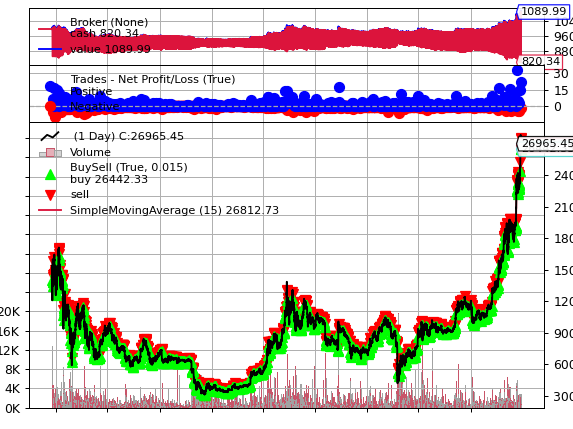

[[<Figure size 640x480 with 4 Axes>]]

In [6]:
cerebro.plot()